# Captain Analysis

In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import os
import json
import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from battleship.run_captain_benchmarks import rebuild_captain_summary_from_results
from battleship.utils import resolve_project_path, PROJECT_ROOT
from battleship.agents import EIGCalculator, CodeQuestion, Question
from battleship.game import Board

from analysis import (
    CAPTAIN_TYPE_LABELS,
    MODEL_DISPLAY_NAMES,
    human_round_summaries,
    build_competitor_column,
    compute_pairwise_win_rates,
    plot_grouped_winrate_heatmap,
    load_dataset,
    plot_question_timing,  # added
)

In [86]:
%config InlineBackend.figure_format = 'retina'

# set seaborn color palette
sns.set_palette("tab10")

# set seaborn style
sns.set_style("whitegrid")
sns.set_context("talk")

In [87]:
HUMAN_EXPERIMENT_NAME = "battleship-final-data"
PATH_DATA = os.path.join("data", HUMAN_EXPERIMENT_NAME)

# PATH_EXPORT = os.path.join(PATH_DATA, "export")
PATH_EXPORT = os.path.join(PROJECT_ROOT, "..", "battleship-iclr-2026", "iclr2026", "_figures_staging") # Export directly into the paper draft

CAPTAIN_EXPERIMENT_PATH = (
    "experiments/collaborative/captain_benchmarks/"
)

## Data loading

### Human data

In [88]:
human_df = human_round_summaries(
    experiment_path=PATH_DATA,
)
human_df = pd.DataFrame(human_df)

human_df = human_df.assign(llm="Human")
human_df

                        gameID       ended  timeoutGameEnd  gameCompleted
22  01JJ2SEBPTDG0QW8S395B2NSB8  game ended            True          False
These will be kept in the dataset.


,captain_type,spotter_type,round_id,board_id,hits,misses,precision,recall,f1_score,is_won,question_count,llm
0,human,human,01JDMZVSGBA3PJBC5AY3SB613R,B03,13,17,0.433333,1.000000,0.604651,True,13,Human
1,human,human,01JDMZWAWZ285CAQTCRXPHG1FQ,B04,12,28,0.300000,0.923077,0.452830,False,3,Human
2,human,human,01JDN0GYZPS3DEFJRWYAE14GQM,B03,12,28,0.300000,0.923077,0.452830,False,4,Human
3,human,human,01JDN0VKDN87TVWWHBYDJBY8NR,B16,18,11,0.620690,1.000000,0.765957,True,8,Human
4,human,human,01JDN0YJBF5TJSXNKP39DX8EXN,B12,9,23,0.281250,1.000000,0.439024,True,1,Human
...,...,...,...,...,...,...,...,...,...,...,...,...
121,human,human,01JJZ4GATW03WJS39WVN0S87EY,B17,13,9,0.590909,1.000000,0.742857,True,1,Human
122,human,human,01JJZ4PE7A3F1K85AZ7SK4AKBS,B04,13,18,0.419355,1.000000,0.590909,True,2,Human
123,human,human,01JJZ4ZY4T4E01TV5H8BAAPAF3,B16,18,18,0.500000,1.000000,0.666667,True,2,Human
124,human,human,01JJZ58JHCAYV885N5T0TD9MW7,B06,10,27,0.270270,1.000000,0.425532,True,2,Human


### Model data

In [89]:
model_round_data_unresolved_paths = [
    ("gpt-4o", "run_2025_08_25_16_28_19"),
    ("gpt-5", "run_2025_08_25_22_02_29"),
    ("llama-4-scout", "run_2025_08_26_17_56_46"),
    ("Baseline", "run_2025_08_26_17_23_23"),
]

model_round_data_paths = [
    (name, resolve_project_path(os.path.join(CAPTAIN_EXPERIMENT_PATH, path)))
    for name, path in model_round_data_unresolved_paths
]
for name, path in model_round_data_paths:
    if not os.path.exists(path):
        print(f"The path {path} does not exist.")

dfs = []
for name, path in model_round_data_paths:
    df = pd.DataFrame(rebuild_captain_summary_from_results(path))
    if df.empty:
        continue
    df["llm"] = name
    df["run_dir"] = path  # retain run directory for downstream file access
    dfs.append(df)

model_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
model_df

,captain_type,spotter_type,round_id,board_id,seed,hits,misses,is_won,question_count,precision,recall,f1_score,llm,run_dir
0,LLMDecisionCaptain_cot,Spotter,eb53acf4,B12,1337,8,32,False,15,0.200000,0.888889,0.326531,gpt-4o,/home/ubuntu/new_battleship/battleship/experim...
1,LLMDecisionCaptain_cot,Spotter,0559f6dd,B02,42,11,29,False,15,0.275000,0.916667,0.423077,gpt-4o,/home/ubuntu/new_battleship/battleship/experim...
2,LLMDecisionCaptain_cot,Spotter,78aa851e,B05,42,14,26,False,11,0.350000,0.933333,0.509091,gpt-4o,/home/ubuntu/new_battleship/battleship/experim...
3,LLMDecisionCaptain_cot,Spotter,855642ba,B11,1337,15,13,True,15,0.535714,1.000000,0.697674,gpt-4o,/home/ubuntu/new_battleship/battleship/experim...
4,EIGCaptain_cot,Spotter,8755e242,B02,111,10,30,False,15,0.250000,0.833333,0.384615,gpt-4o,/home/ubuntu/new_battleship/battleship/experim...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,RandomCaptain,Spotter,2d6a7901,B13,1337,11,29,False,0,0.275000,0.733333,0.400000,Baseline,/home/ubuntu/new_battleship/battleship/experim...
590,MAPCaptain,Spotter,7606dd63,B01,111,12,12,True,0,0.500000,1.000000,0.666667,Baseline,/home/ubuntu/new_battleship/battleship/experim...
591,RandomCaptain,Spotter,a3a9e371,B17,42,8,32,False,0,0.200000,0.615385,0.301887,Baseline,/home/ubuntu/new_battleship/battleship/experim...
592,RandomCaptain,Spotter,7c20cbc3,B04,42,8,32,False,0,0.200000,0.615385,0.301887,Baseline,/home/ubuntu/new_battleship/battleship/experim...


In [90]:
# Append summary_df to round_df
df = pd.concat([human_df, model_df], ignore_index=True)

primary_columns = ["captain_type_display", "llm_display", "board_id", "seed"]

# Create categorical column for captain_type_display
df["captain_type_display"] = pd.Categorical(
    df["captain_type"].map(CAPTAIN_TYPE_LABELS),
    categories=list(dict.fromkeys(CAPTAIN_TYPE_LABELS.values())),
    ordered=True,
)

# Create categorical column for llm_display
df["llm_display"] = pd.Categorical(
    df["llm"],
    categories=["Human", "Baseline"] + [x for x in MODEL_DISPLAY_NAMES.values() if x in df["llm"].unique()],
    ordered=True,
)

# Move primary columns to the front
df = df[primary_columns + [col for col in df.columns if col not in primary_columns]]

# Sort the DataFrame by primary columns
df = df.sort_values(by=primary_columns, ascending=True).reset_index(drop=True)

df

,captain_type_display,llm_display,board_id,seed,captain_type,spotter_type,round_id,hits,misses,precision,recall,f1_score,is_won,question_count,llm,run_dir
0,Human,Human,B01,NaN,human,human,01JDN15S5CEJ0EFRF1BBQAR61A,12,23,0.342857,1.000000,0.510638,True,2,Human,NaN
1,Human,Human,B01,NaN,human,human,01JDN4116HF7HQJSHNS8HEK3NE,12,20,0.375000,1.000000,0.545455,True,15,Human,NaN
2,Human,Human,B01,NaN,human,human,01JFFX0ZPTKKDP75FZ7NZZZMPT,11,29,0.275000,0.916667,0.423077,False,15,Human,NaN
3,Human,Human,B01,NaN,human,human,01JG2RXQ8TFT1754V71A4WJ60M,12,12,0.500000,1.000000,0.666667,True,8,Human,NaN
4,Human,Human,B01,NaN,human,human,01JJ5SN0G4S5M9H2Q8AGX4R08G,11,29,0.275000,0.916667,0.423077,False,4,Human,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,MAP + EIG,gpt-5,B17,111.0,MAPEIGCaptain_cot,Spotter,ce88177d,13,8,0.619048,1.000000,0.764706,True,7,gpt-5,/home/ubuntu/new_battleship/battleship/experim...
716,MAP + EIG,gpt-5,B17,1337.0,MAPEIGCaptain_cot,Spotter,b0e2059e,13,12,0.520000,1.000000,0.684211,True,4,gpt-5,/home/ubuntu/new_battleship/battleship/experim...
717,MAP + EIG,gpt-5,B18,42.0,MAPEIGCaptain_cot,Spotter,82e88822,11,12,0.478261,1.000000,0.647059,True,12,gpt-5,/home/ubuntu/new_battleship/battleship/experim...
718,MAP + EIG,gpt-5,B18,111.0,MAPEIGCaptain_cot,Spotter,e0bc4a67,11,7,0.611111,1.000000,0.758621,True,7,gpt-5,/home/ubuntu/new_battleship/battleship/experim...


In [91]:
# group sizes, then drop any groups with size == 0
group_sizes = df.groupby(["captain_type_display", "llm_display"]).size()
group_sizes = group_sizes[group_sizes != 0]

# nicer tabular view if needed
group_counts = group_sizes.reset_index(name="count")
group_counts

/tmp/ipykernel_1124/1820806141.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sizes = df.groupby(["captain_type_display", "llm_display"]).size()


,captain_type_display,llm_display,count
0,Human,Human,126
1,Random,Baseline,54
2,MAP,Baseline,54
3,LLM,llama-4-scout,54
4,LLM,gpt-4o,54
5,LLM,gpt-5,54
6,EIG,llama-4-scout,54
7,EIG,gpt-4o,54
8,EIG,gpt-5,54
9,MAP + EIG,llama-4-scout,54


## Precision/Recall Stats

In [92]:
print("\nBreakdown by captain_type_display:")
for captain_type in df['captain_type_display'].cat.categories:
    llms = df[df['captain_type_display'] == captain_type]['llm'].unique()
    print(f"{captain_type}: {llms}")


# Colorblind-friendly palette (Okabe–Ito)
llm_palette = {
    "Human": "#009E73",  # green
    "Baseline": "#0072B2",  # blue
    "llama-4-scout": "#CC79A7",  # purple
    "gpt-4o": "#E69F00",  # orange (similar to gpt-5)
    "gpt-5": "#D55E00",  # vermillion
}


Breakdown by captain_type_display:
Human: ['Human']
Random: ['Baseline']
MAP: ['Baseline']
LLM: ['llama-4-scout' 'gpt-4o' 'gpt-5']
EIG: ['llama-4-scout' 'gpt-4o' 'gpt-5']
MAP + EIG: ['llama-4-scout' 'gpt-4o' 'gpt-5']


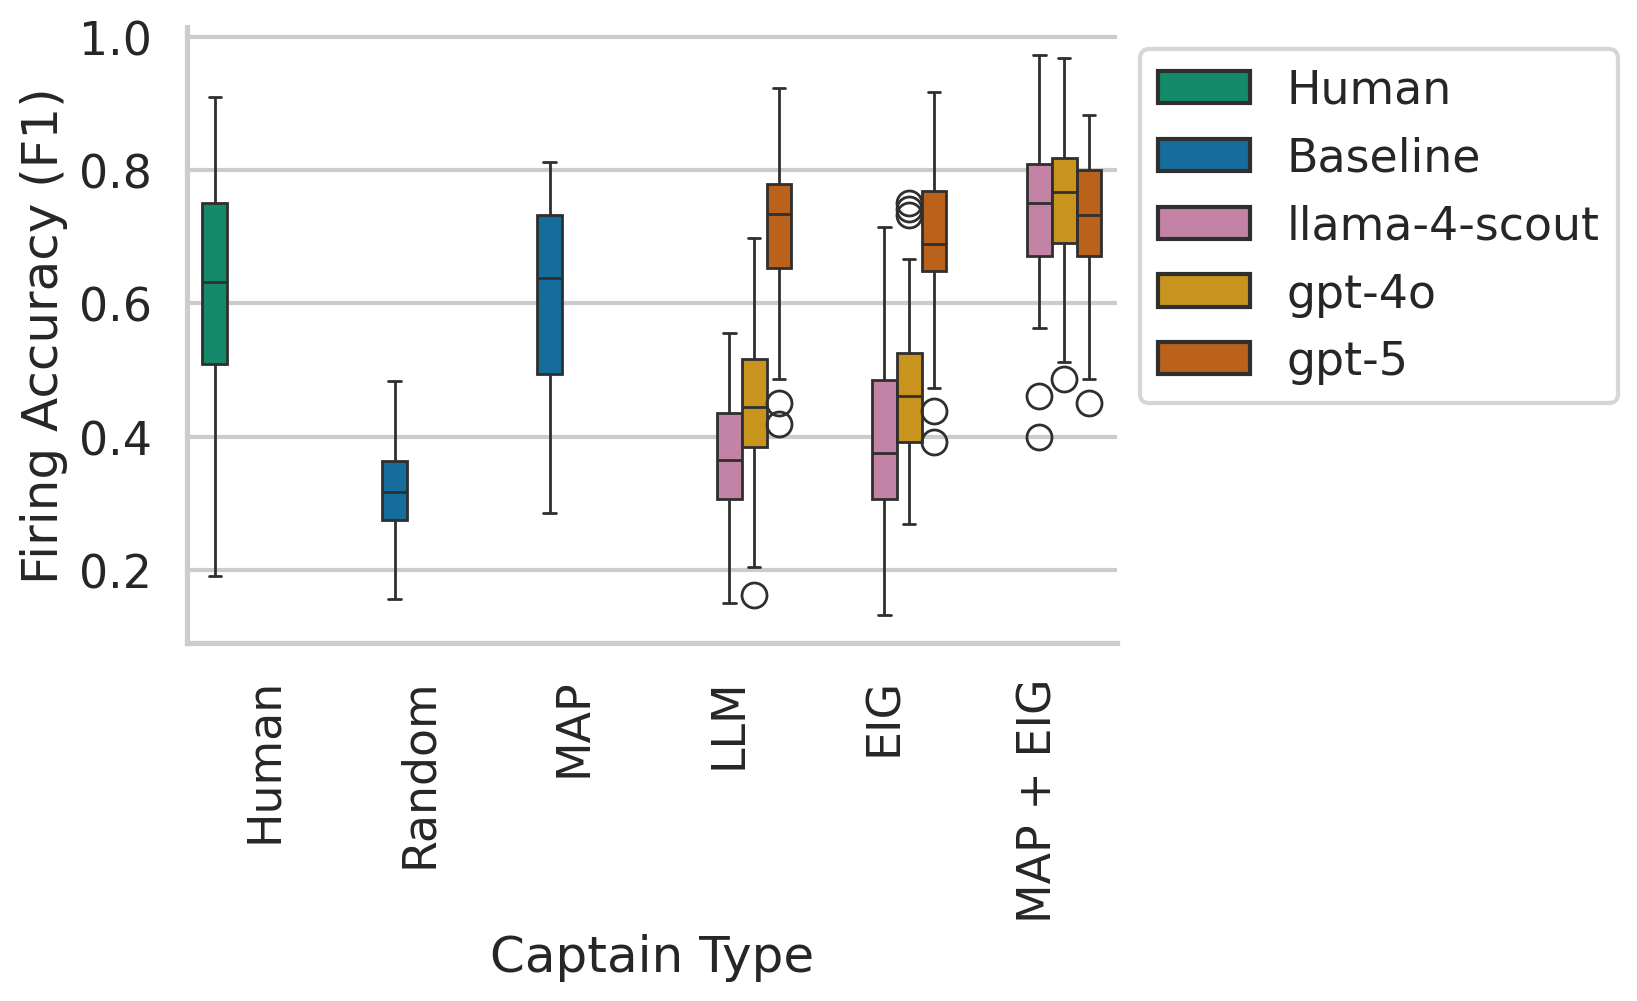

In [93]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(
    data=df,
    x="captain_type_display",
    y="f1_score",
    hue="llm",
    palette=llm_palette,
    ax=ax,
)
sns.despine()

plt.xlabel("Captain Type")
plt.ylabel("Firing Accuracy (F1)")

plt.xticks(rotation=90)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="")

plt.show()

/tmp/ipykernel_1124/3479800863.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  llm_counts = df.groupby("captain_type_display")["llm"].nunique()


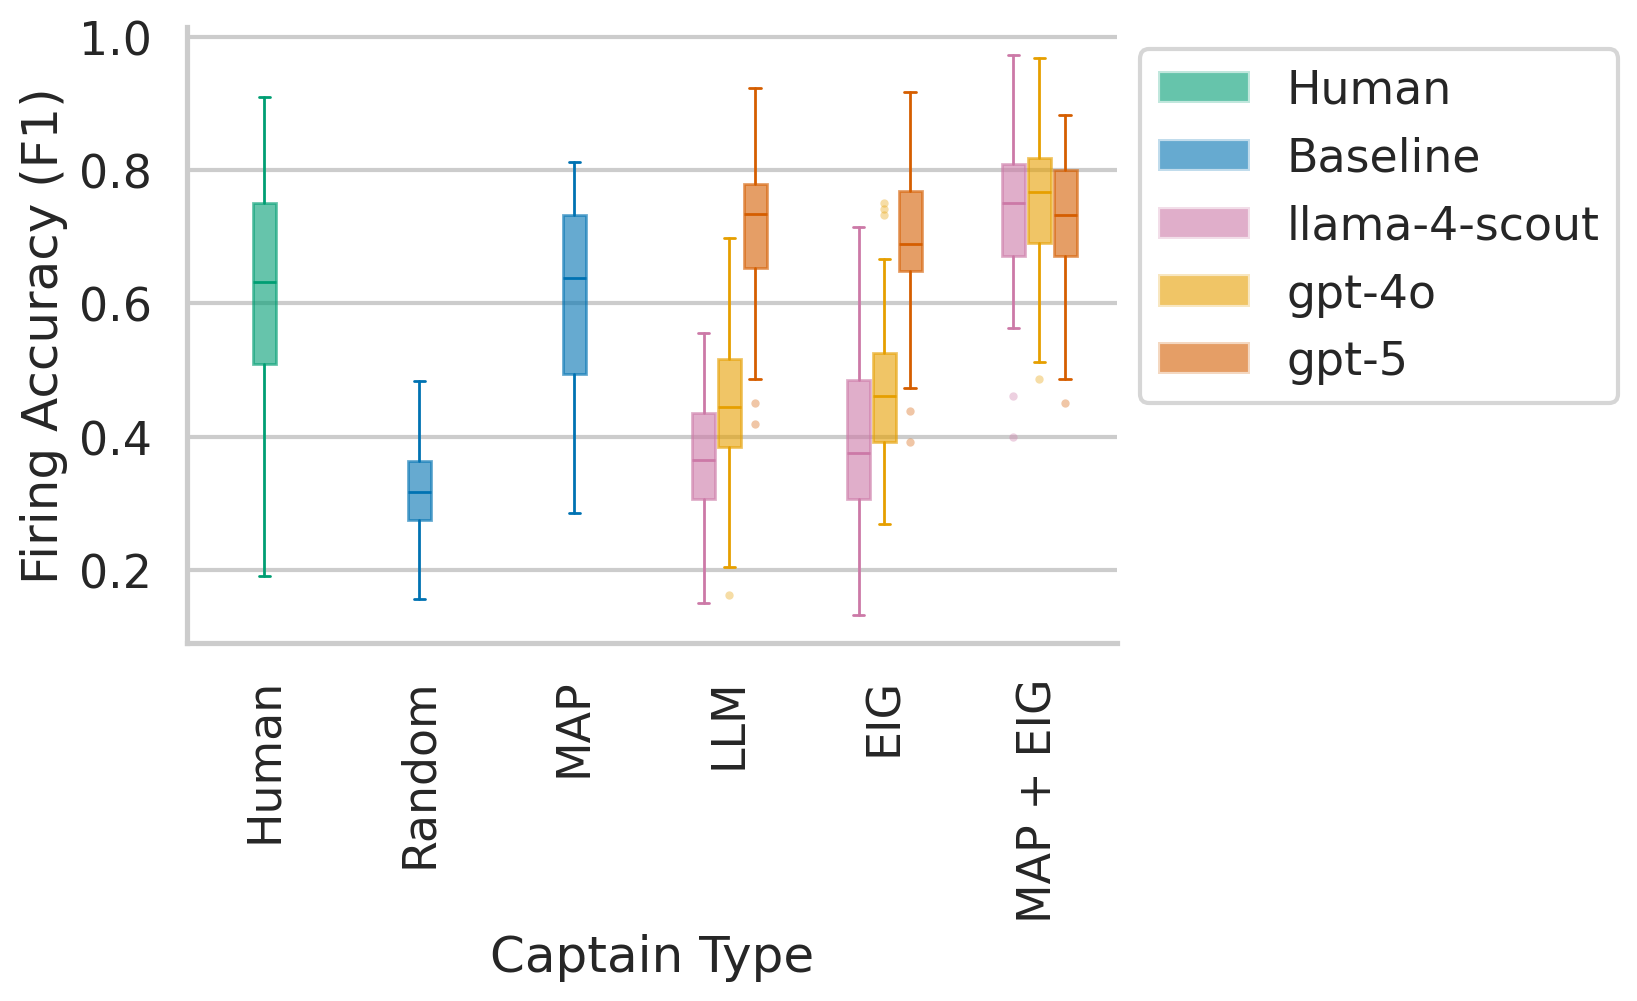

In [94]:
fig, ax = plt.subplots(figsize=(6, 4))

# Prepare ordered captain categories that actually appear in the data
captain_categories = [
    c for c in df["captain_type_display"].cat.categories
    if c in df["captain_type_display"].values
]

# Determine max number of llm groups present for any captain (for consistent box widths)
llm_counts = df.groupby("captain_type_display")["llm"].nunique()
max_llms = int(llm_counts.max()) if len(llm_counts) > 0 else 1

# Base positions for each captain on the x axis
x_positions = np.arange(len(captain_categories))

# Box width: leave some padding between captain groups
group_width = 0.5  # total width occupied by boxes for one captain
box_width = group_width / max_llms

# Ensure grid lines are drawn below plot elements and only horizontal gridlines are shown
ax.set_axisbelow(True)
ax.xaxis.grid(False)
ax.yaxis.grid(True)

# Map captain -> present llms to ensure we only plot existing combinations
# Use the llm_display categorical ordering so order is consistent across plots
llm_order = list(df["llm_display"].cat.categories) if "llm_display" in df.columns else sorted(df["llm"].unique())

for i, captain in enumerate(captain_categories):
    present_llms_unsorted = df[df["captain_type_display"] == captain]["llm"].unique()
    # Preserve the display order
    present_llms = [llm for llm in llm_order if llm in present_llms_unsorted]

    m = len(present_llms)
    if m == 0:
        continue

    # Offsets to center m boxes around the captain x position
    offsets = (np.arange(m) - (m - 1) / 2.0) * box_width

    for j, llm in enumerate(present_llms):
        subset = df[(df["captain_type_display"] == captain) & (df["llm"] == llm)]["f1_score"].dropna()
        if subset.empty:
            continue

        pos = x_positions[i] + offsets[j]
        color = llm_palette.get(llm, "#808080")

        # Use matplotlib's boxplot to place each box at the computed numeric position
        bp = ax.boxplot(subset.values,
                        positions=[pos],
                        widths=box_width * 0.9,
                        patch_artist=True,
                        manage_ticks=False)

        # Style the box elements
        for element in ["boxes", "whiskers", "caps", "medians"]:
            plt.setp(bp[element], color=color)
        for patch in bp["boxes"]:
            patch.set(facecolor=color, alpha=0.6)

        # Make fliers (outliers) less visually distinctive: smaller, lower-alpha, and same color as box
        if "fliers" in bp:
            for f in bp["fliers"]:
                f.set(marker='o', markersize=3, markerfacecolor=color, markeredgecolor=color, alpha=0.35, markeredgewidth=0)

# Create legend handles for llm types present in the full DataFrame, in llm_display order
from matplotlib.patches import Patch
all_present_llms = [llm for llm in llm_order if llm in df["llm"].unique()]
legend_handles = [Patch(facecolor=llm_palette[k], label=k, alpha=0.6) for k in all_present_llms]

ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), title="")

# Final formatting
ax.set_xticks(x_positions)
ax.set_xticklabels(captain_categories, rotation=90)
ax.set_xlabel("Captain Type")
ax.set_ylabel("Firing Accuracy (F1)")
ax.set_xlim(-0.5, len(captain_categories) - 0.5)

sns.despine()
# plt.tight_layout()
# plt.show()

#plt.savefig(os.path.join(PATH_EXPORT, "captain_f1_boxplot.pdf"), dpi=300, bbox_inches="tight")

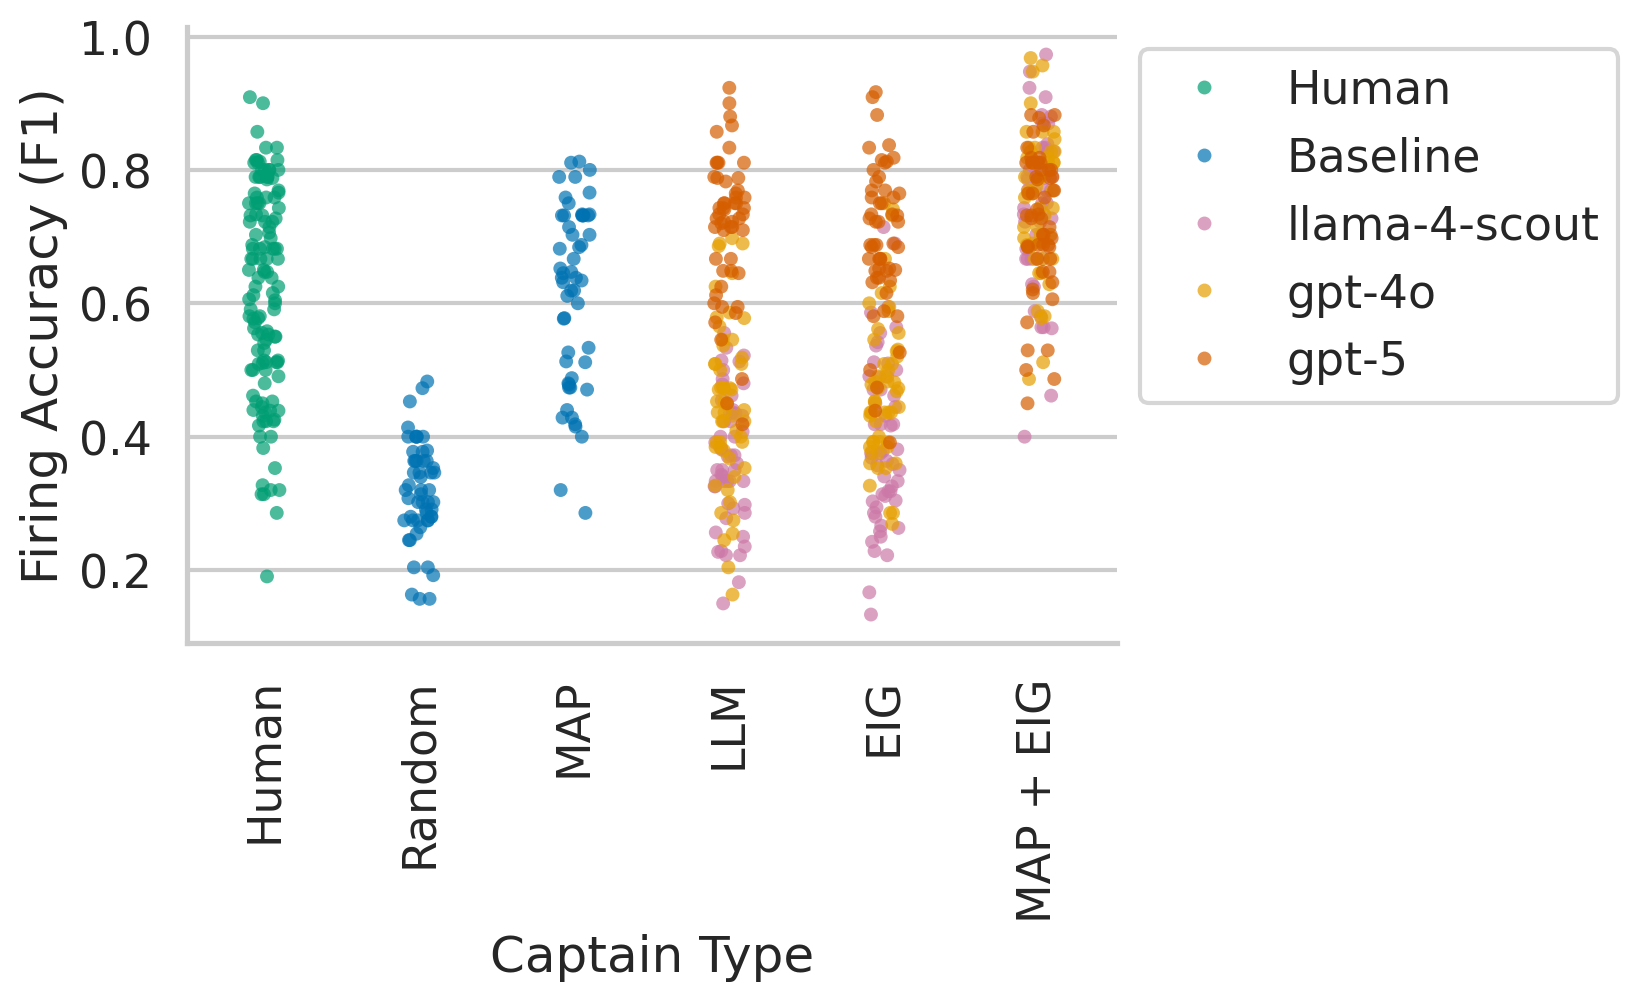

In [95]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.stripplot(
    data=df,
    x="captain_type_display",
    y="f1_score",
    hue="llm",
    palette=llm_palette,
    alpha=0.7,
    ax=ax,
)
sns.despine()

plt.xlabel("Captain Type")
plt.ylabel("Firing Accuracy (F1)")

plt.xticks(rotation=90)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="")

plt.show()

/home/ubuntu/miniconda3/envs/battleship_data/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


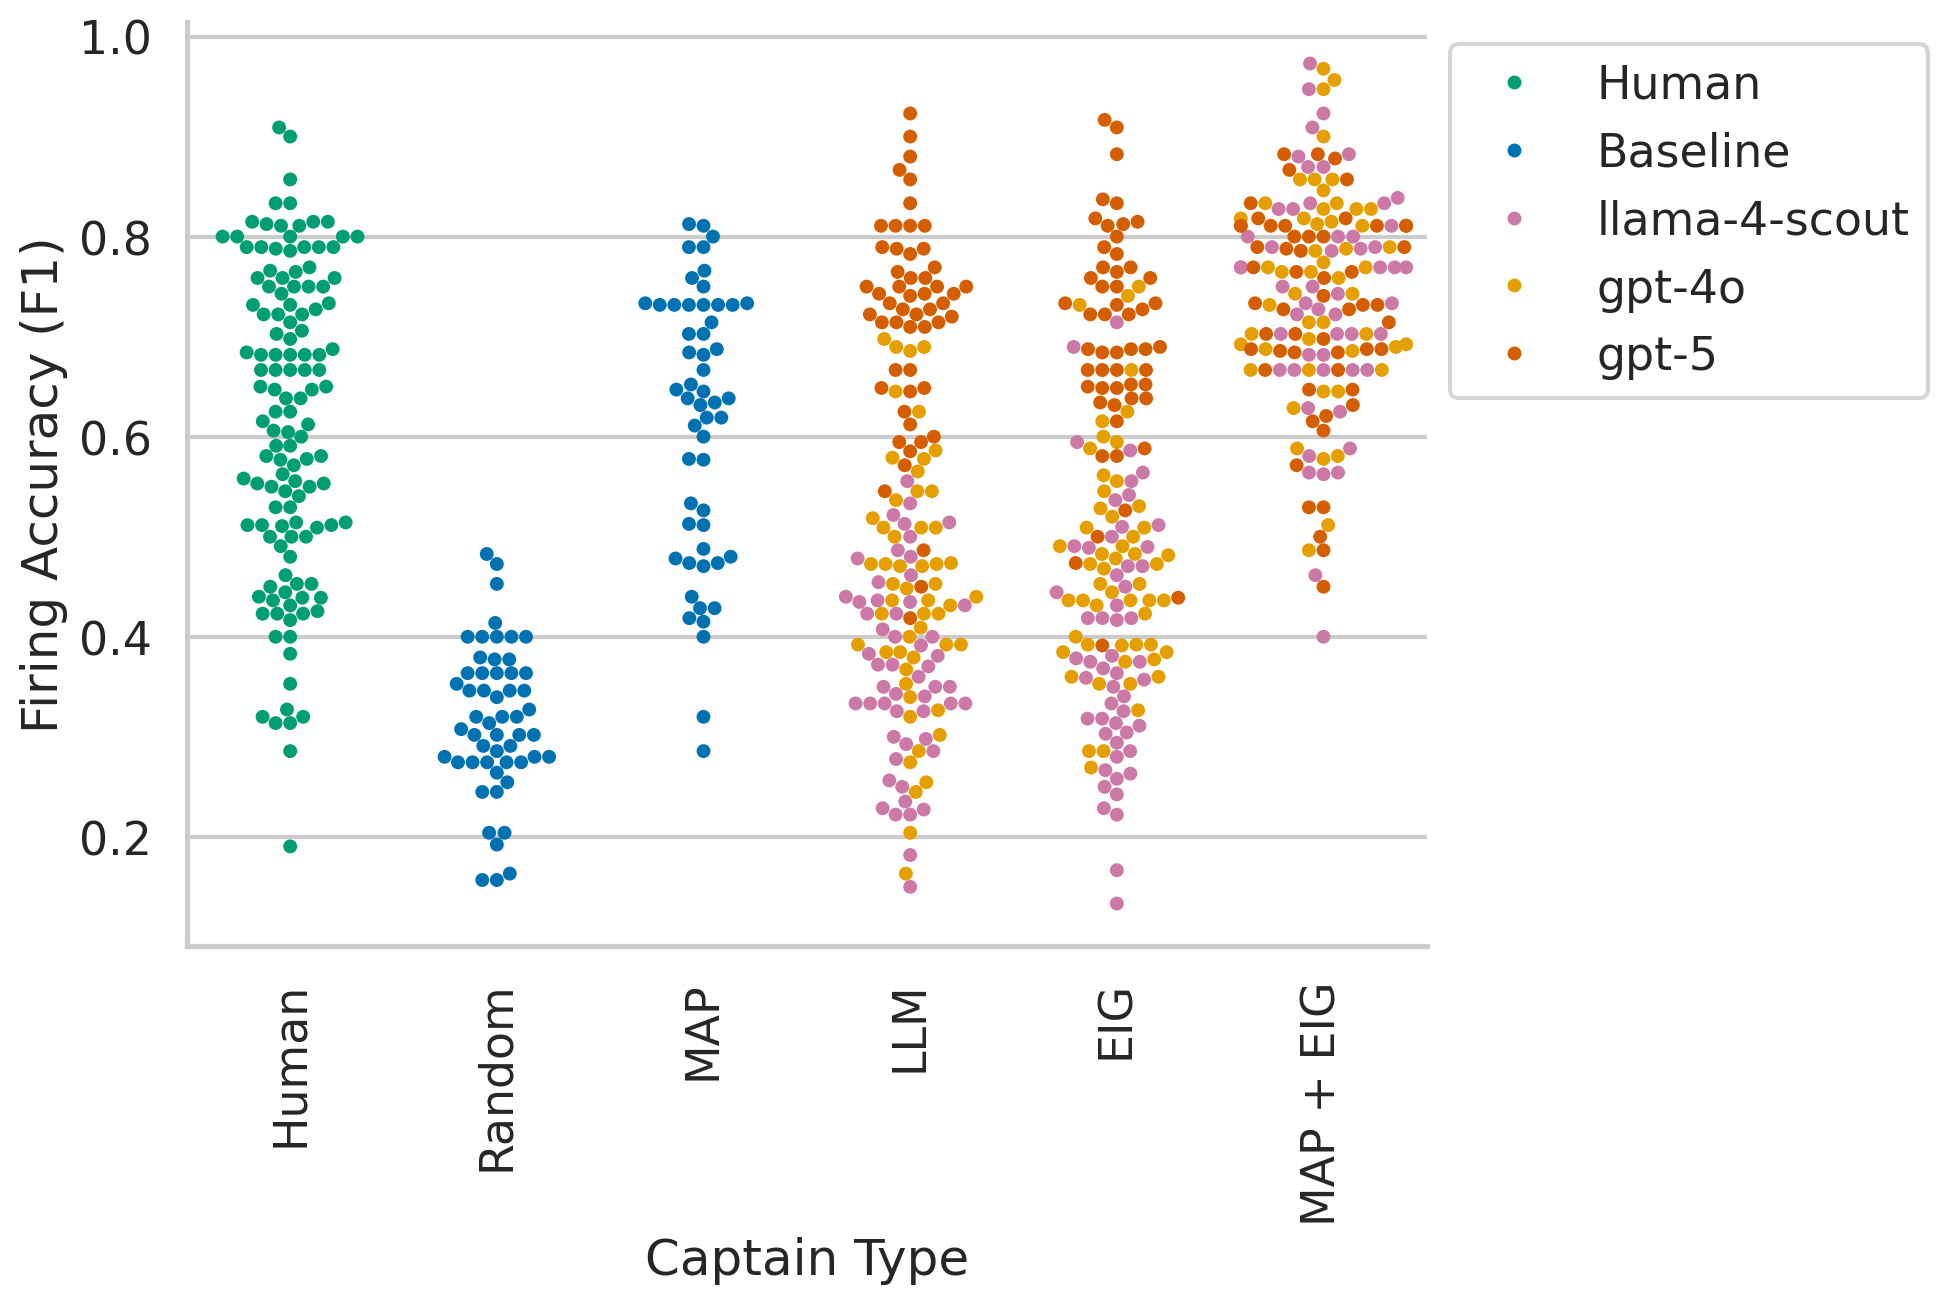

In [96]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.swarmplot(
    data=df,
    x="captain_type_display",
    y="f1_score",
    hue="llm",
    palette=llm_palette,
    # alpha=0.7,
    ax=ax,
)
sns.despine()

plt.xlabel("Captain Type")
plt.ylabel("Firing Accuracy (F1)")

plt.xticks(rotation=90)

ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="")

plt.show()


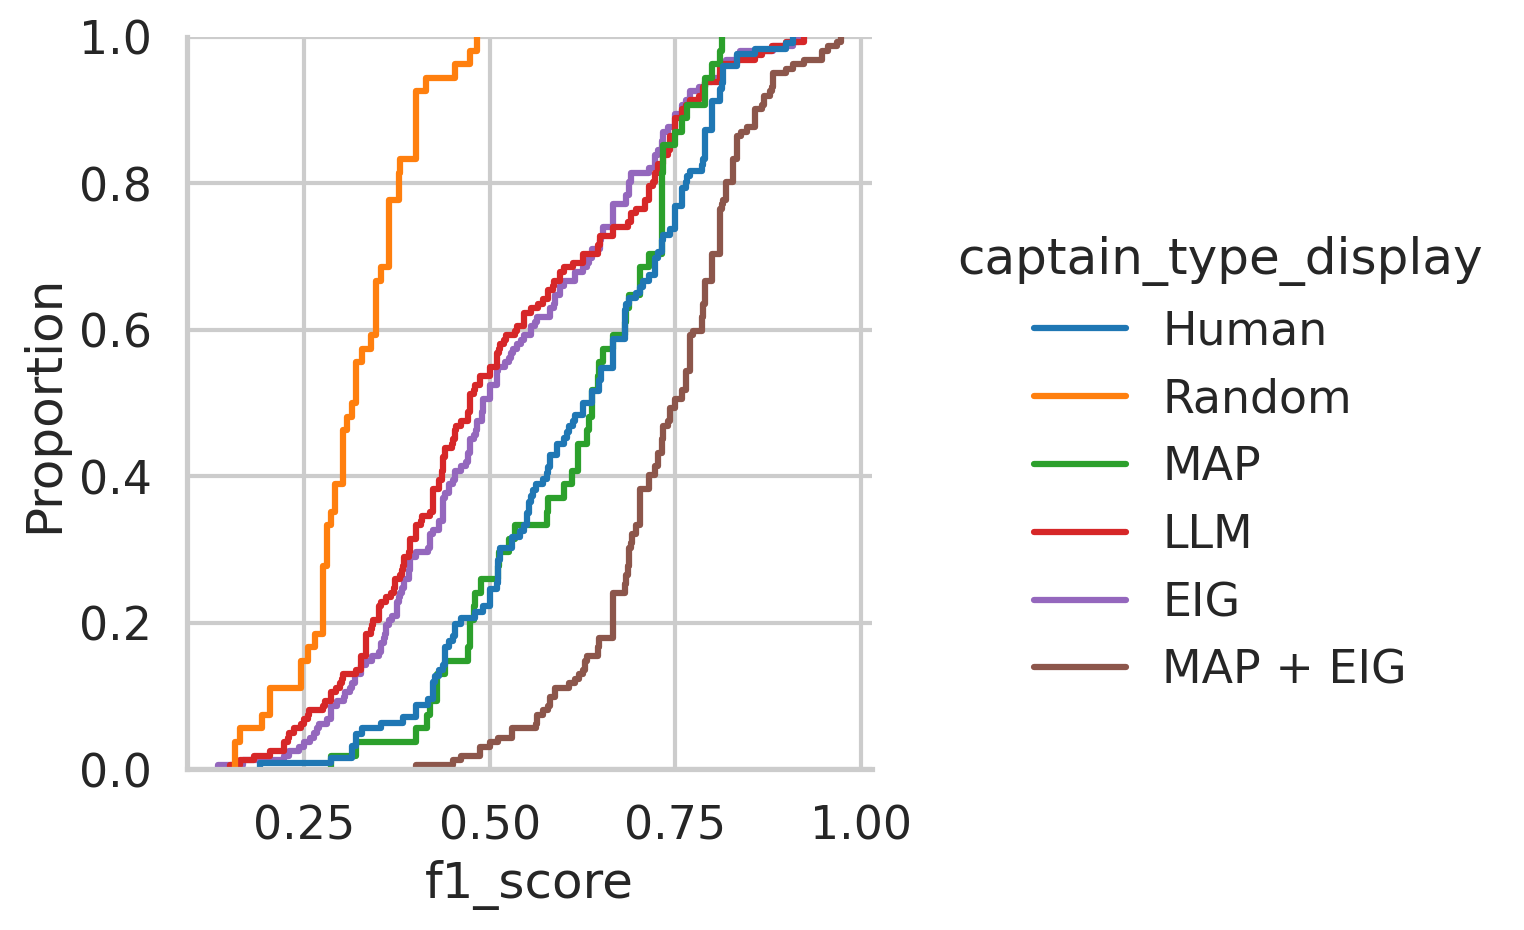

In [97]:
sns.displot(
    data=df,
    kind="ecdf",
    x="f1_score",
    hue="captain_type_display",
)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'human'),
  Text(1, 0, 'RandomCaptain'),
  Text(2, 0, 'MAPCaptain'),
  Text(3, 0, 'LLMDecisionCaptain_cot'),
  Text(4, 0, 'EIGCaptain_cot'),
  Text(5, 0, 'MAPEIGCaptain_cot')])

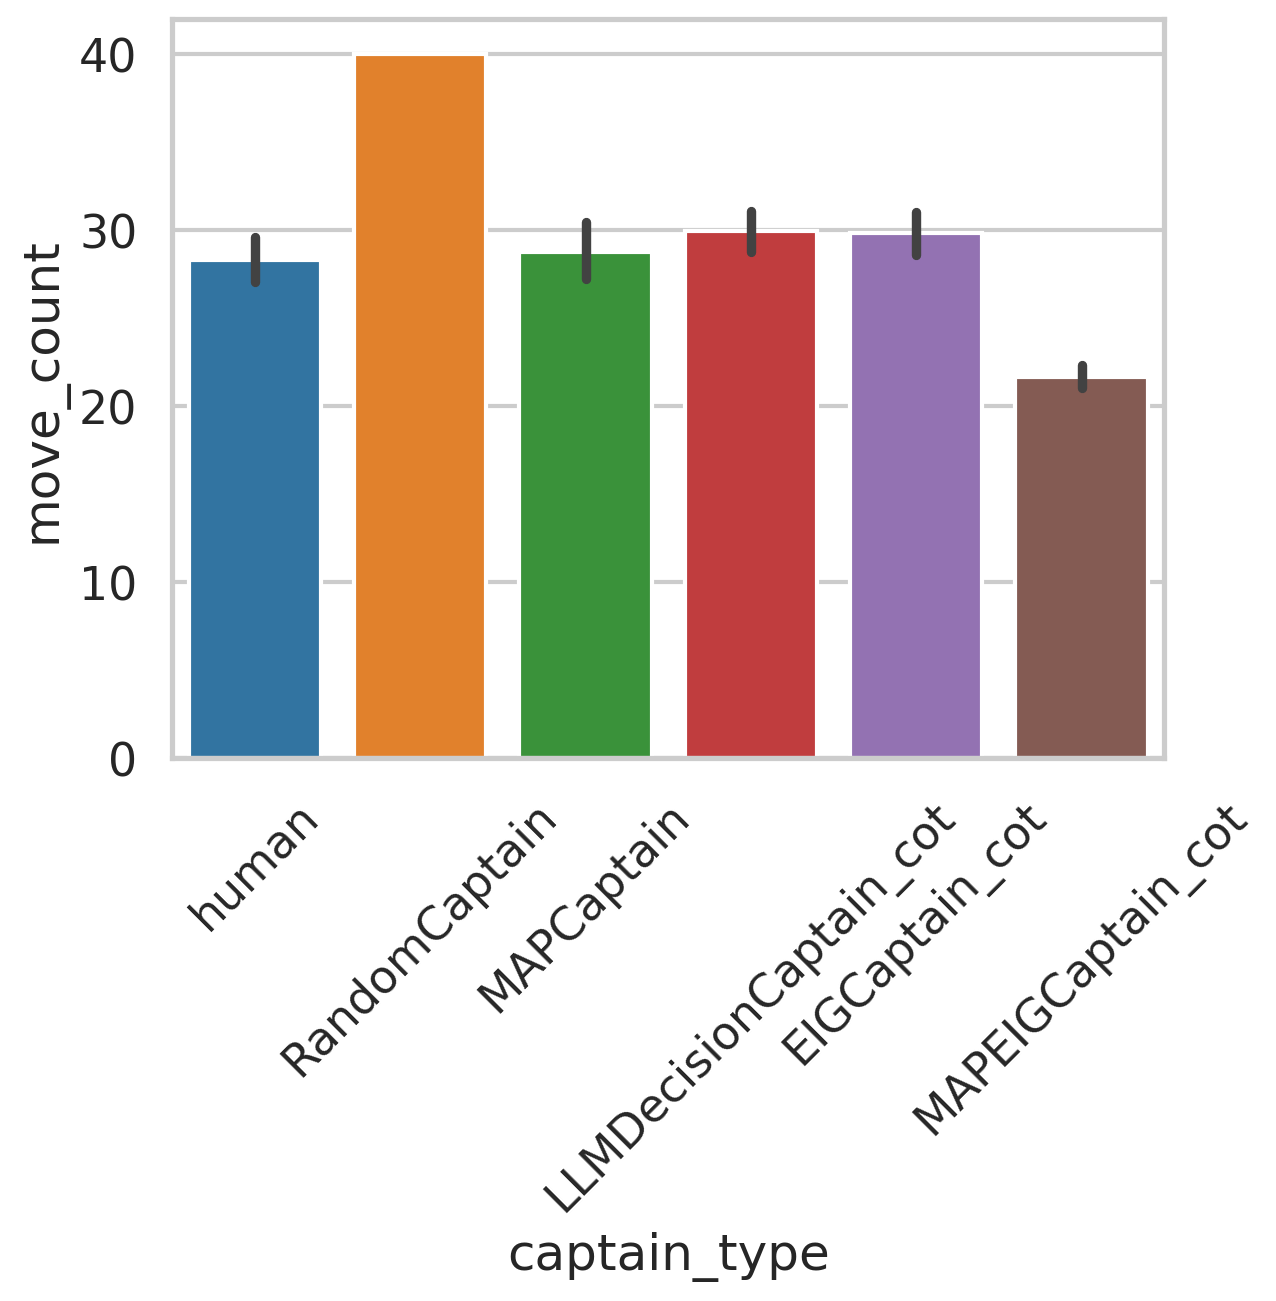

In [98]:
df["move_count"] = df["hits"] + df["misses"]

sns.barplot(data=df, x="captain_type", y="move_count", hue="captain_type")
plt.xticks(rotation=45)

## Win rates

In [99]:
# Build competitor column (LLM first | Captain)
df = build_competitor_column(df, llm_col="llm_display", captain_col="captain_type_display", out_col="competitor")

# Compute win rates for F1 (higher better)
win_results_f1_comp = compute_pairwise_win_rates(
    df, metric="f1_score", higher_is_better=True, competitor_col="competitor", board_col="board_id"
)
print("Mean board win rate matrix (F1, competitor-level):")
display(win_results_f1_comp["mean_board_win_rate_matrix"])
# print("Weighted all-pairs win rate matrix (F1, competitor-level):")
# display(win_results_f1_comp["weighted_win_rate_matrix"])

# # Compute win rates for move count (lower better) if available
# if "move_count" in df.columns:
#     win_results_moves_comp = compute_pairwise_win_rates(
#         df, metric="move_count", higher_is_better=False, competitor_col="competitor", board_col="board_id"
#     )
#     print("Mean board win rate matrix (Move Count, competitor-level):")
#     display(win_results_moves_comp["mean_board_win_rate_matrix"])
#     print("Weighted all-pairs win rate matrix (Move Count, competitor-level):")
#     display(win_results_moves_comp["weighted_win_rate_matrix"])
# else:
#     print("Column 'move_count' not found; skip move-count win rates.")

# Aggregate summary for F1
# f1_comp_summary = win_results_f1_comp["aggregate"][[
#     "competitor_a", "competitor_b", "mean_board_win_rate", "weighted_all_pairs_win_rate", "boards_considered", "board_wins", "board_comparisons"
# ]].sort_values(["competitor_a", "competitor_b"]).reset_index(drop=True)
# print("Pairwise aggregate win rates (F1, competitor-level):")
# display(f1_comp_summary)

/home/ubuntu/new_battleship/battleship/experiments/collaborative/analysis.py:465: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([competitor_col, board_col])


Mean board win rate matrix (F1, competitor-level):


,Human | Human,Baseline | Random,Baseline | MAP,llama-4-scout | LLM,llama-4-scout | EIG,llama-4-scout | MAP + EIG,gpt-4o | LLM,gpt-4o | EIG,gpt-4o | MAP + EIG,gpt-5 | LLM,gpt-5 | EIG,gpt-5 | MAP + EIG
Human | Human,0.500000,0.976190,0.535714,0.917989,0.891534,0.219577,0.800265,0.797619,0.187831,0.257937,0.350529,0.236772
Baseline | Random,0.023810,0.500000,0.003086,0.317901,0.290123,0.000000,0.148148,0.043210,0.000000,0.000000,0.000000,0.000000
Baseline | MAP,0.464286,0.996914,0.500000,0.981481,0.913580,0.154321,0.845679,0.861111,0.117284,0.179012,0.191358,0.123457
llama-4-scout | LLM,0.082011,0.682099,0.018519,0.500000,0.419753,0.000000,0.253086,0.148148,0.006173,0.000000,0.000000,0.000000
llama-4-scout | EIG,0.108466,0.709877,0.086420,0.580247,0.500000,0.037037,0.314815,0.283951,0.018519,0.009259,0.030864,0.012346
llama-4-scout | MAP + EIG,0.780423,1.000000,0.845679,1.000000,0.962963,0.500000,0.944444,0.913580,0.419753,0.586420,0.651235,0.595679
gpt-4o | LLM,0.199735,0.851852,0.154321,0.746914,0.685185,0.055556,0.500000,0.425926,0.033951,0.043210,0.061728,0.043210
gpt-4o | EIG,0.202381,0.956790,0.138889,0.851852,0.716049,0.086420,0.574074,0.500000,0.064815,0.061728,0.077160,0.052469
gpt-4o | MAP + EIG,0.812169,1.000000,0.882716,0.993827,0.981481,0.580247,0.966049,0.935185,0.500000,0.592593,0.703704,0.623457
gpt-5 | LLM,0.742063,1.000000,0.820988,1.000000,0.990741,0.413580,0.956790,0.938272,0.407407,0.500000,0.623457,0.481481


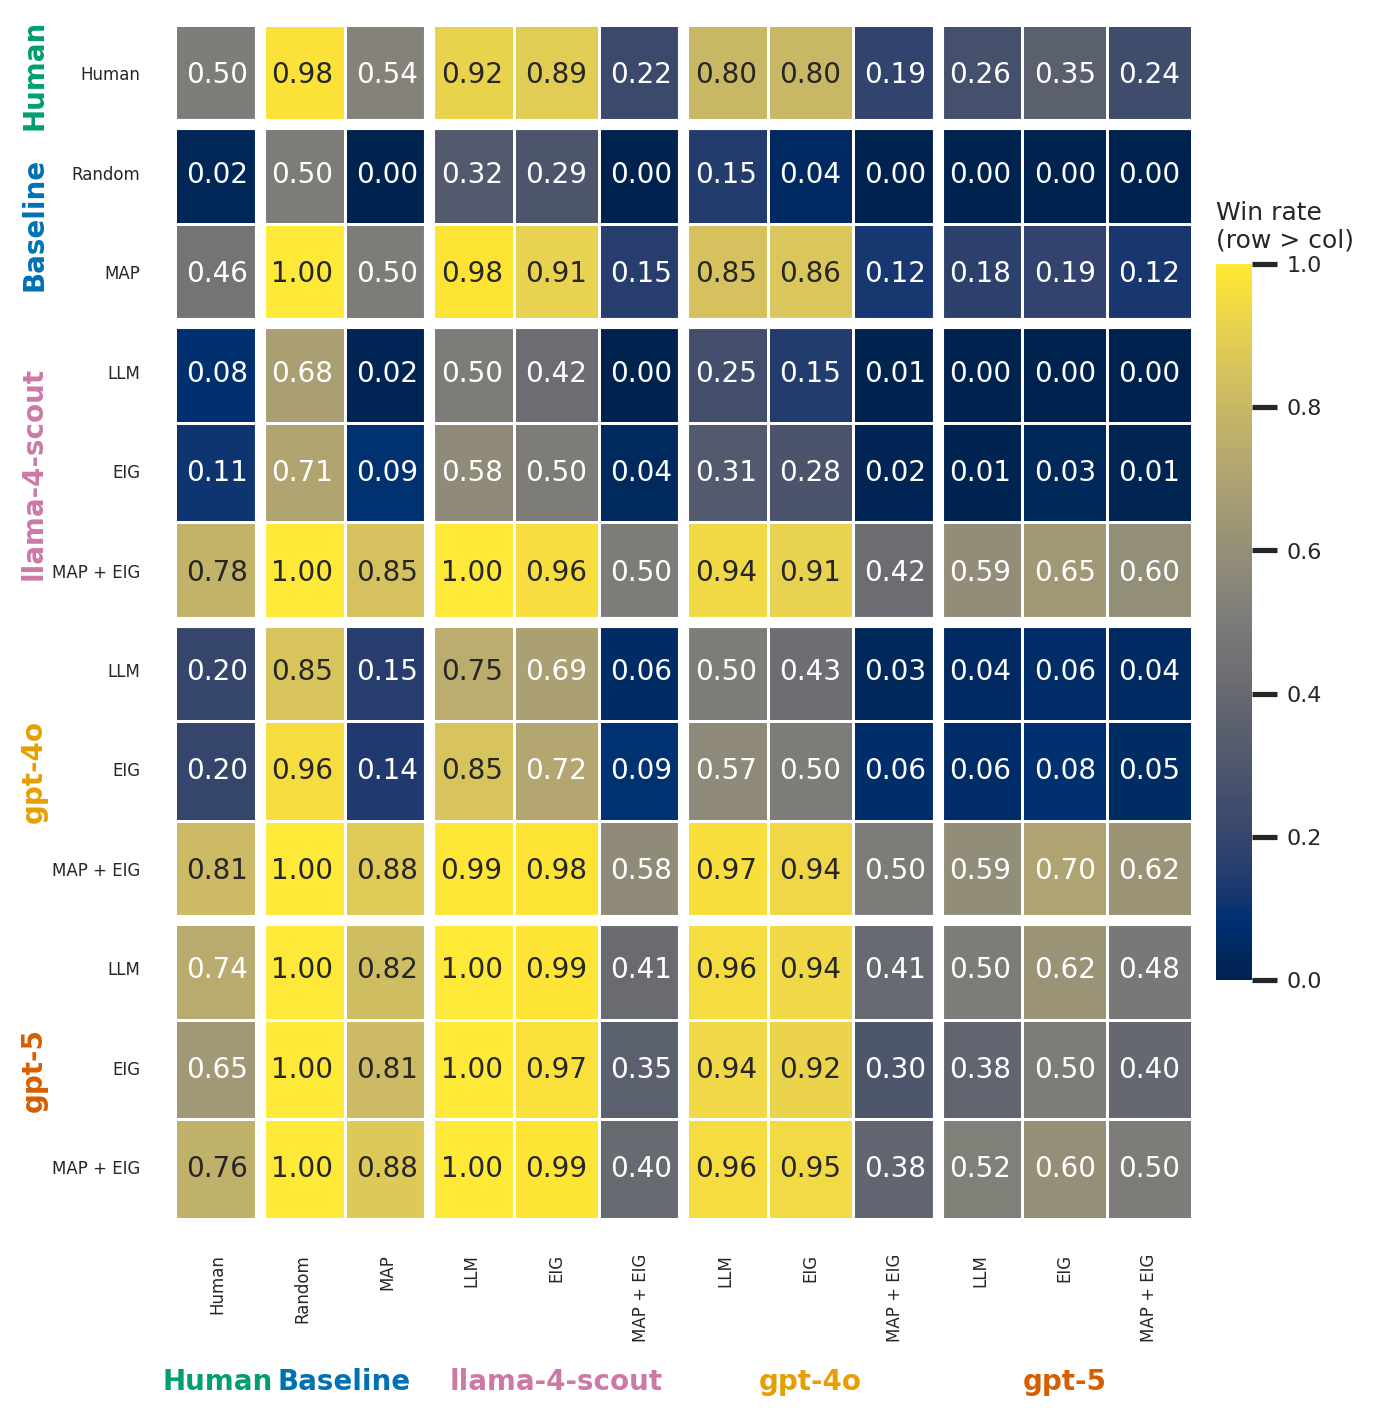

In [100]:
# Grouped heatmap using refactored helper
base_matrix = win_results_f1_comp["weighted_win_rate_matrix"].copy().astype(float)

fig, ax = plot_grouped_winrate_heatmap(
    base_matrix,
    llm_palette=llm_palette,
    cmap="cividis",
    annotate=True,
    captain_tick_fontsize=6,
    row_alpha=1.0,
    col_alpha=1.0,
    show_group_separators=True,
    separator_width=4,
    shade_rows=True,
    shade_cols=True,
    group_label_rotation=90,
    group_label_fontsize=10,
    output_path=os.path.join(PATH_EXPORT, "f1_winrate_heatmap.pdf"),
    title=None,
)

## EIG Stats

In [101]:
# --- Theoretical Maximum EIG (shared) -------------------------------------------
# Defines a reusable constant THEORETICAL_MAX_EIG based on epsilon.
# Other cells (ECDF delta, running max curves) will reference this instead of recomputing.
import numpy as np
from battleship.agents import binary_entropy

EIG_EPSILON = 0.1  # noise / error probability parameter
THEORETICAL_MAX_EIG = binary_entropy(p=0.5) - binary_entropy(EIG_EPSILON)
print(f"Set THEORETICAL_MAX_EIG={THEORETICAL_MAX_EIG:.4f} for epsilon={EIG_EPSILON}")

Set THEORETICAL_MAX_EIG=0.5310 for epsilon=0.1


In [102]:
# --- Model EIG Extraction (All Runs) -----------------------------------------
# Build EIG table directly from model_df metadata (no filename round parsing).
from pathlib import Path
import json
import pandas as pd

# Guard: ensure model_df exists
if 'model_df' not in globals() or model_df.empty:
    model_question_df = pd.DataFrame()
else:
    # We expect columns: llm, run_dir, round_id, captain_type
    required = {"llm", "run_dir", "round_id", "captain_type"}
    missing = required - set(model_df.columns)
    if missing:
        print(f"Missing columns in model_df: {missing}; cannot extract EIG.")
        model_question_df = pd.DataFrame()
    else:
        records = []
        # Iterate unique (llm, run_dir, round_id, captain_type)
        for _, row in model_df.iterrows():
            captain_json = Path(row.run_dir) / "rounds" / f"round_{row.round_id}" / "captain" / "captain.json"
            if not captain_json.exists():
                continue
            try:
                with captain_json.open() as f:
                    entries = json.load(f)
            except Exception:
                continue

            def extract_stage_index(entry):
                stage_index = entry.get("stage_index")
                if not stage_index:
                    stage_index = 0
                return stage_index

            # compute max stage and check monotonicity of stage_index across entries
            stage_indices = [extract_stage_index(e) for e in entries]
            max_stage_index = max(stage_indices) if stage_indices else 0

            # Data-integrity check: stage_index should never decrease
            decreases = []
            for i in range(1, len(stage_indices)):
                if stage_indices[i] < stage_indices[i - 1]:
                    decreases.append((i - 1, i, stage_indices[i - 1], stage_indices[i]))

            if decreases:
                print(
                    "WARNING: Stage index decreased for run:",
                    f"captain_type={row.captain_type}, llm={row.llm}, board_id={row.board_id}, seed={row.seed}"
                )
                for prev_i, cur_i, prev_s, cur_s in decreases:
                    print(f"  entries[{prev_i}].stage_index={prev_s} -> entries[{cur_i}].stage_index={cur_s}")

            for idx, entry in enumerate(entries):
                stage_index = extract_stage_index(entry)
                stage_completion = stage_index / max_stage_index if max_stage_index > 0 else 0.0
                eig_value = entry.get("eig")
                q_block = entry.get("question")
                if eig_value is None or q_block is None:
                    continue
                # Nested question text extraction
                if isinstance(q_block, dict):
                    inner_q = q_block.get("question")
                    q_text = inner_q.get("text") if isinstance(inner_q, dict) else None
                else:
                    q_text = None
                q_text = q_text or "No question text"

                raw_candidates = entry.get("eig_questions") or []
                processed = None
                if raw_candidates:
                    processed = [
                        (
                            c.get("question", {})
                            .get("question", {})
                            .get("text"),
                            c.get("eig"),
                            None,
                        )
                        for c in raw_candidates
                    ]
                    vals = [c[1] for c in processed if c[1] is not None]
                    if vals:
                        mx = max(vals)
                        processed = [(qt, ev, ev == mx) for (qt, ev, _) in processed]

                records.append(
                    {
                        "captain_type": row.captain_type,
                        "llm": row.llm,
                        "board_id": row.board_id,
                        "seed": row.seed,
                        "stage_index": stage_index,
                        "stage_completion": stage_completion,
                        "run_dir": row.run_dir,
                        "round_id": row.round_id,
                        "index": idx,
                        "question": q_text,
                        "eig": eig_value,
                        "eig_candidates": processed,
                    }
                )
        model_question_df = pd.DataFrame(records)
        if not model_question_df.empty:
            model_question_df = model_question_df.sort_values(["llm", "round_id", "index"]).reset_index(drop=True)

# Add captain_type_display similar to main df
if not model_question_df.empty and 'CAPTAIN_TYPE_LABELS' in globals():
    model_question_df['captain_type_display'] = model_question_df['captain_type'].map(CAPTAIN_TYPE_LABELS)
    # Preserve order used elsewhere
    cat_order = [x for x in dict.fromkeys(CAPTAIN_TYPE_LABELS.values()) if x in model_question_df['captain_type_display'].unique()]
    model_question_df['captain_type_display'] = pd.Categorical(model_question_df['captain_type_display'], categories=cat_order, ordered=True)

# Derive llm_display here (moved earlier as requested)
if not model_question_df.empty and 'llm_display' not in model_question_df.columns:
    if 'df' in globals() and 'llm_display' in df.columns:
        llm_display_map = (
            df.dropna(subset=['llm_display'])
              .drop_duplicates('llm')
              [['llm','llm_display']]
              .set_index('llm')['llm_display']
              .to_dict()
        )
        model_question_df['llm_display'] = model_question_df['llm'].map(llm_display_map).fillna(model_question_df['llm'])
    else:
        model_question_df['llm_display'] = model_question_df['llm']

# Align categorical ordering with main df if available
if not model_question_df.empty and 'df' in globals() and 'llm_display' in df.columns and hasattr(df['llm_display'], 'cat'):
    model_question_df['llm_display'] = pd.Categorical(
        model_question_df['llm_display'],
        categories=list(df['llm_display'].cat.categories),
        ordered=True,
    )

model_question_df

,captain_type,llm,board_id,seed,stage_index,stage_completion,run_dir,round_id,index,question,eig,eig_candidates,captain_type_display,llm_display
0,EIGCaptain_cot,gpt-4o,B01,42,0,0.000000,/home/ubuntu/new_battleship/battleship/experim...,05180dac,1,"Are there any ship parts present in row D, col...",0.530781,[(Is there a ship in rows A-D and columns 1-4?...,EIG,gpt-4o
1,EIGCaptain_cot,gpt-4o,B01,42,2,0.048780,/home/ubuntu/new_battleship/battleship/experim...,05180dac,5,"Are there any ship parts in row C, columns 4 t...",0.530808,"[(Are there any ship parts in row C, columns 4...",EIG,gpt-4o
2,EIGCaptain_cot,gpt-4o,B01,42,4,0.097561,/home/ubuntu/new_battleship/battleship/experim...,05180dac,9,"Are there any ship parts in row C, columns 2 t...",0.523114,"[(Are there any ship parts in row E, columns 4...",EIG,gpt-4o
3,EIGCaptain_cot,gpt-4o,B01,42,8,0.195122,/home/ubuntu/new_battleship/battleship/experim...,05180dac,17,"Are there any ship parts present in row D, col...",0.530731,[(Are there any ship parts present in column 2...,EIG,gpt-4o
4,EIGCaptain_cot,gpt-4o,B01,42,9,0.219512,/home/ubuntu/new_battleship/battleship/experim...,05180dac,19,Are there any ship parts present in row A?,0.468902,"[(Are there any ship parts present in row A?, ...",EIG,gpt-4o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5739,LLMDecisionCaptain_cot,llama-4-scout,B09,111,19,0.358491,/home/ubuntu/new_battleship/battleship/experim...,fd2d25c2,39,Is there a ship in B3 or B8?,0.256797,None,LLM,llama-4-scout
5740,LLMDecisionCaptain_cot,llama-4-scout,B09,111,22,0.415094,/home/ubuntu/new_battleship/battleship/experim...,fd2d25c2,45,"Is there a ship in A4, A5, A6, A7, or A8?",0.496855,None,LLM,llama-4-scout
5741,LLMDecisionCaptain_cot,llama-4-scout,B09,111,30,0.566038,/home/ubuntu/new_battleship/battleship/experim...,fd2d25c2,61,"Is there a ship in G1, H1, G2, or H2?",0.290238,None,LLM,llama-4-scout
5742,LLMDecisionCaptain_cot,llama-4-scout,B09,111,33,0.622642,/home/ubuntu/new_battleship/battleship/experim...,fd2d25c2,67,Is there a ship in G3 or H3?,0.144135,None,LLM,llama-4-scout


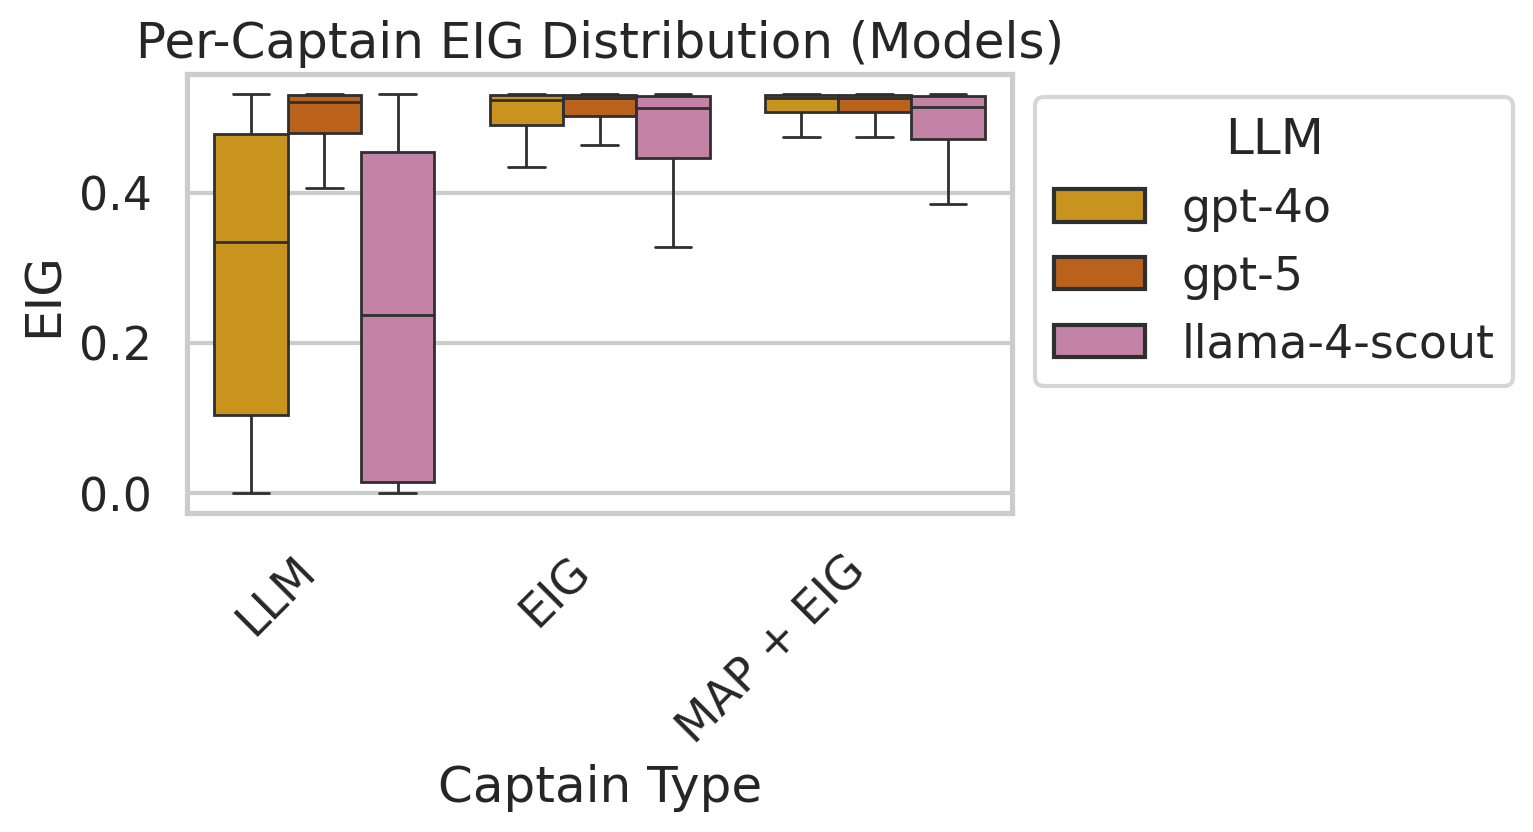

In [103]:
# --- Per-Captain EIG Distribution --------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

if 'model_question_df' not in globals() or model_question_df.empty:
    print("model_eig_df is empty; run the EIG extraction cell first.")
else:
    x_col = 'captain_type_display' if 'captain_type_display' in model_question_df.columns else 'captain_type'

    plt.figure(figsize=(8, 4.5))
    ax = sns.boxplot(
        data=model_question_df,
        x=x_col,
        y='eig',
        hue='llm',
        palette=llm_palette,
        showfliers=False,
    )

    ax.set_xlabel('Captain Type')
    ax.set_ylabel('EIG')
    ax.set_title('Per-Captain EIG Distribution (Models)')
    plt.xticks(rotation=45, ha='right')
    ax.legend(title='LLM', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [104]:
model_question_df.columns

Index(['captain_type', 'llm', 'board_id', 'seed', 'stage_index',
       'stage_completion', 'run_dir', 'round_id', 'index', 'question', 'eig',
       'eig_candidates', 'captain_type_display', 'llm_display'],
      dtype='object')

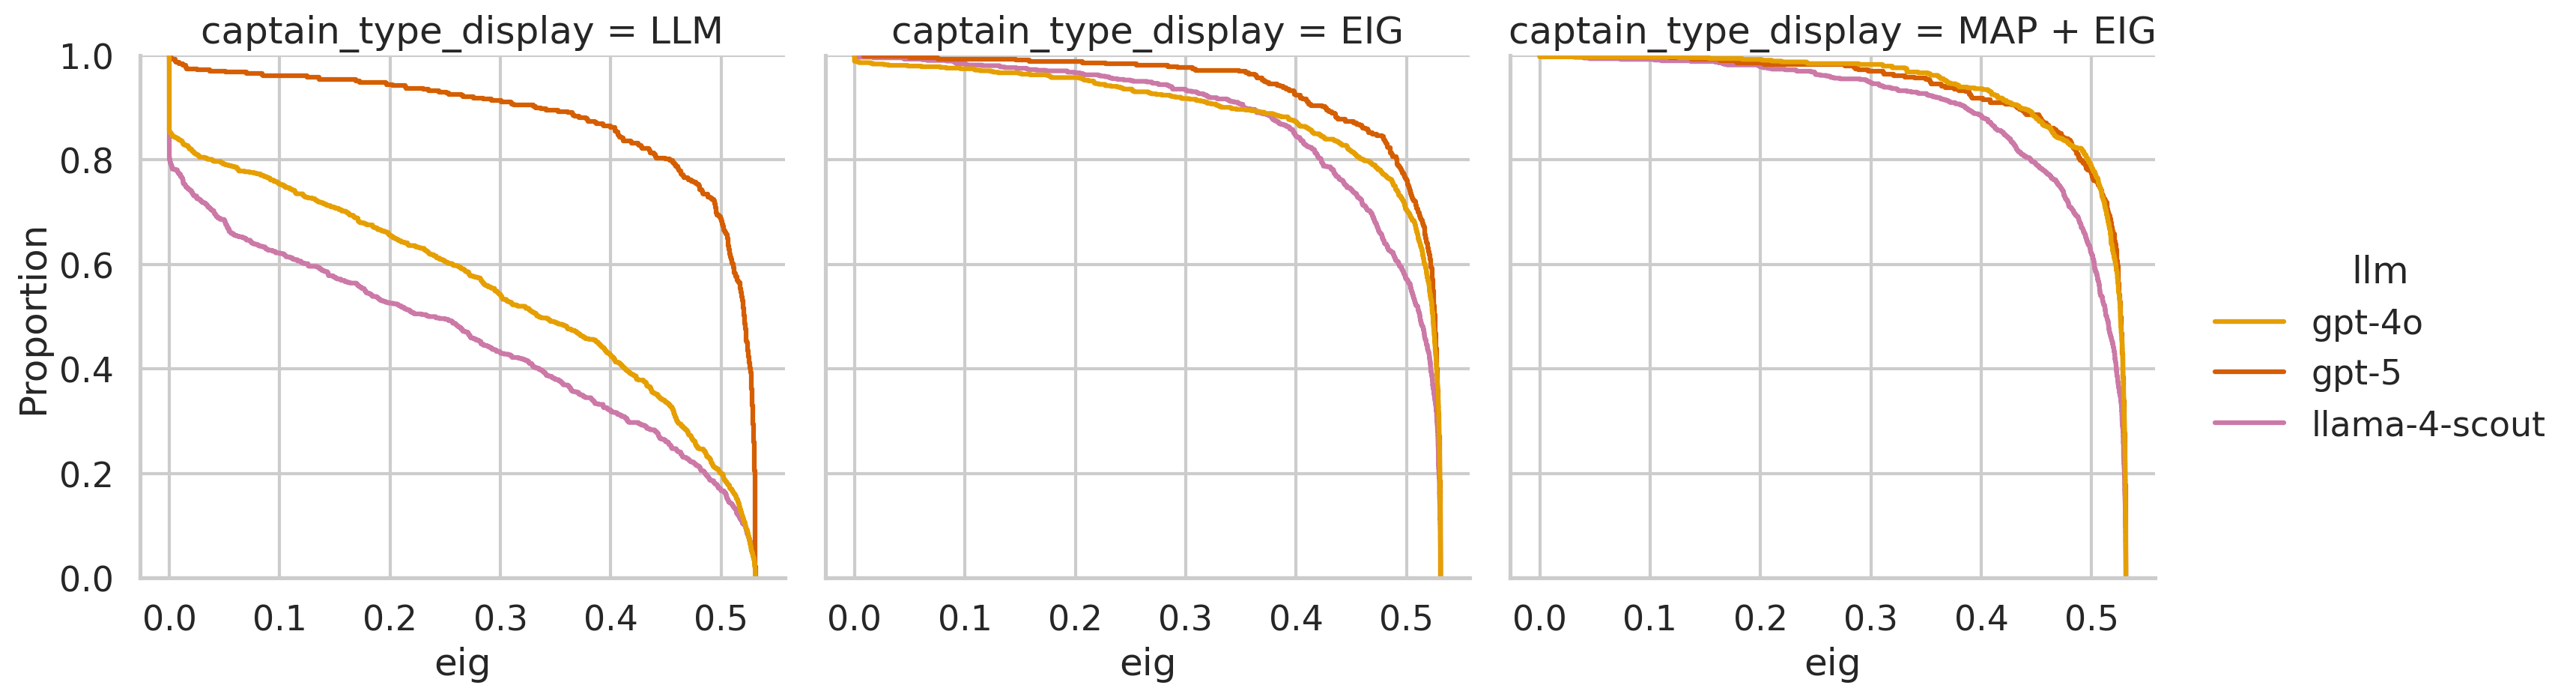

In [105]:
ax = sns.displot(
    data=model_question_df,
    kind="ecdf",
    col="captain_type_display",
    x="eig",
    hue="llm",
    palette=llm_palette,
    complementary=True,
)

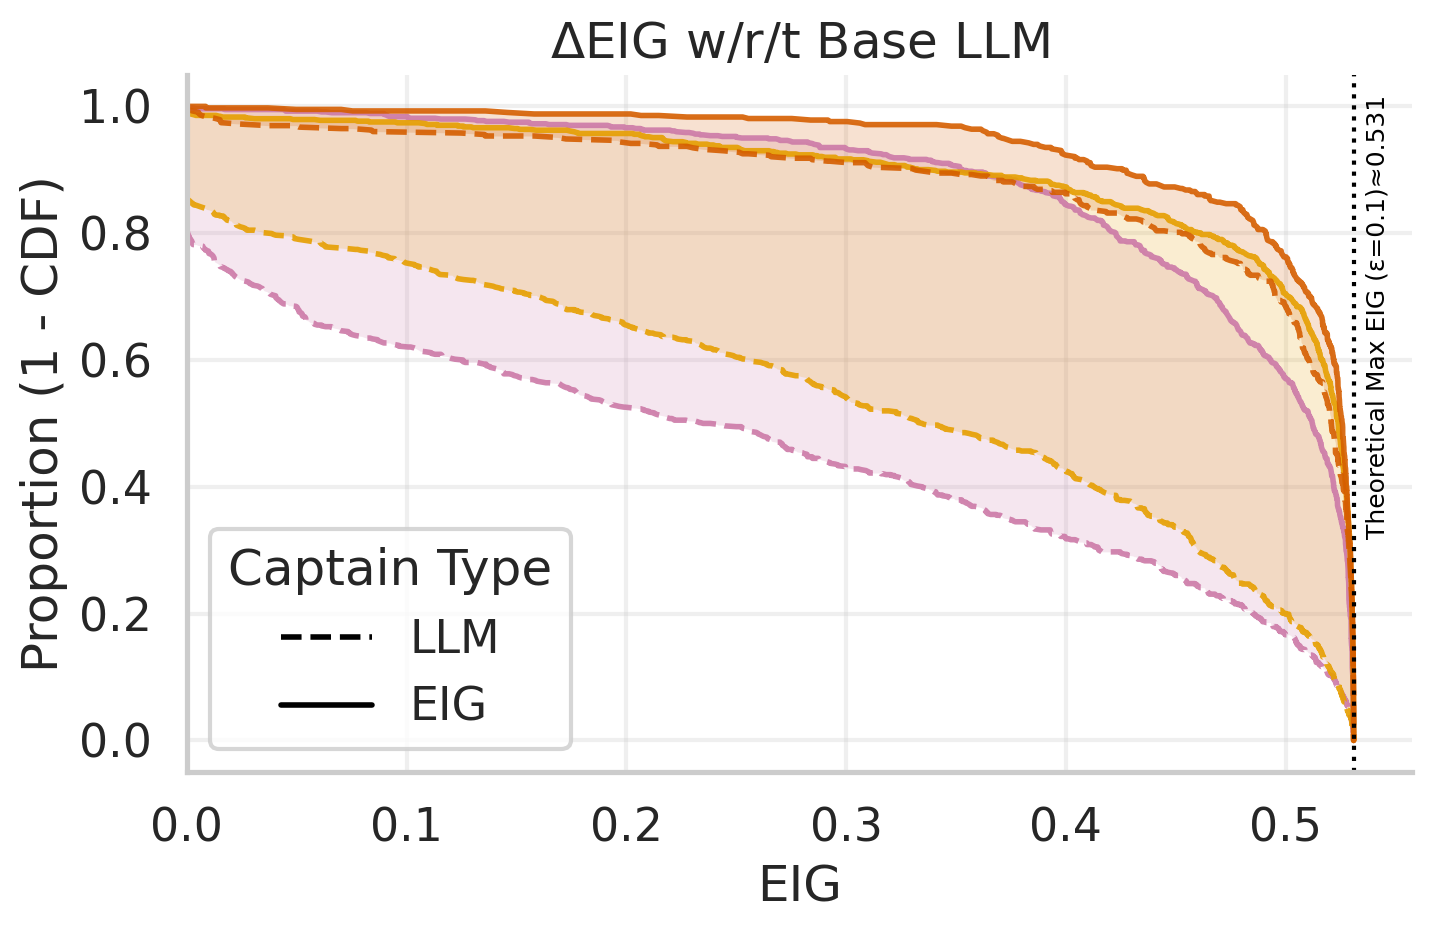

,llm,area_abs_diff
0,llama-4-scout,0.226822
1,gpt-4o,0.180918
2,gpt-5,0.028949


In [106]:
# --- ECDF Delta (LLM vs EIG captain types) -----------------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuration
_ecdf_categories = ("LLM", "EIG")  # (baseline, enhanced)
complementary = True  # match earlier visualization style (survival curves)
alpha_fill = 0.18
linewidth = 2.0

if 'model_question_df' not in globals() or model_question_df.empty:
    print("model_question_df empty; run extraction first.")
else:
    # Ensure required captain types exist
    present_cats = set(model_question_df['captain_type_display'].dropna().unique())
    missing = [c for c in _ecdf_categories if c not in present_cats]
    if missing:
        print(f"Missing categories for delta plot: {missing}")
    else:
        fig, ax = plt.subplots(figsize=(7.5, 5))

        legend_elements = []
        area_rows = []

        for llm in [c for c in llm_palette.keys() if c in model_question_df['llm'].unique()]:
            sub = model_question_df[model_question_df['llm'] == llm]
            # Need both categories for this llm
            if not set(_ecdf_categories).issubset(set(sub['captain_type_display'].unique())):
                continue
            data_a = sub[sub['captain_type_display'] == _ecdf_categories[0]]['eig'].dropna().values
            data_b = sub[sub['captain_type_display'] == _ecdf_categories[1]]['eig'].dropna().values
            if len(data_a) == 0 or len(data_b) == 0:
                continue

            # Build common grid
            grid = np.unique(np.concatenate([data_a, data_b]))
            n_a = len(data_a)
            n_b = len(data_b)
            # ECDF values using searchsorted (right) for F(x) = P(X <= x)
            y_a = np.searchsorted(np.sort(data_a), grid, side='right') / n_a
            y_b = np.searchsorted(np.sort(data_b), grid, side='right') / n_b
            if complementary:
                y_a = 1 - y_a
                y_b = 1 - y_b

            color = llm_palette.get(llm, '#444444')
            # Plot baseline (LLM) dashed, enhanced (EIG) solid
            ax.plot(grid, y_a, linestyle='--', color=color, linewidth=linewidth, alpha=0.9)
            ax.plot(grid, y_b, linestyle='-', color=color, linewidth=linewidth, alpha=0.9)

            # Shade region between curves
            ax.fill_between(grid, y_a, y_b, color=color, alpha=alpha_fill, linewidth=0)

            # Approximate absolute area difference (integral of |delta|) for reference
            area_diff = np.trapz(np.abs(y_b - y_a), grid)
            area_rows.append({'llm': llm, 'area_abs_diff': area_diff})

        # Use shared THEORETICAL_MAX_EIG
        if 'THEORETICAL_MAX_EIG' in globals():
            ax.axvline(THEORETICAL_MAX_EIG, color='k', linestyle=':', linewidth=1.5)
            ymin, ymax = ax.get_ylim()
            ax.text(
                THEORETICAL_MAX_EIG * 1.01,
                ymax * 0.97,
                f"Theoretical Max EIG (ε={EIG_EPSILON})≈{THEORETICAL_MAX_EIG:.3f}",
                rotation=90,
                va='top',
                ha='left',
                fontsize=9,
                color='k'
            )

        ax.set_xlim(left=0)
        ax.set_xlabel('EIG')
        ax.set_ylabel('Proportion (CDF)' if not complementary else 'Proportion (1 - CDF)')
        ax.set_title(r"$\Delta$EIG w/r/t Base LLM")
        ax.grid(alpha=0.3, linestyle="-")

        # Simplified legend: only distinguish line styles (color meaning shown elsewhere)
        from matplotlib.lines import Line2D
        style_handles = [
            Line2D([0,1],[0,1], color='k', linestyle='--', linewidth=linewidth, label=_ecdf_categories[0]),
            Line2D([0,1],[0,1], color='k', linestyle='-', linewidth=linewidth, label=_ecdf_categories[1]),
        ]
        ax.legend(handles=style_handles, loc='lower left', frameon=True, title='Captain Type')

        sns.despine()
        plt.tight_layout()

        plt.savefig(
            os.path.join(PATH_EXPORT, "eig_ecdf_delta.pdf"),
            bbox_inches='tight',
            dpi=300,
        )

        plt.show()

        if area_rows:
            area_df = pd.DataFrame(area_rows).sort_values('area_abs_diff', ascending=False)
            display(area_df.reset_index(drop=True))

### Growth of max EIG with number of candidate questions
We fix the captain type to `EIG` and, for every model/round row in `model_eig_df`, compute the running maximum EIG obtainable when only the first k candidate questions are considered (k = 1..N). We then average these curves across rows for each LLM type and plot one line per LLM.

Preview eig_candidates (first 3 of first non-empty row): [('Is there a ship in rows A-D and columns 1-4?', 0.25293250129808087, False), ('Are there any parts of a ship located in the central 4x4 region, covering coordinates D3 to E6?', 0.2464861487761455, False), ('Is there any part of a ship in the upper left quadrant made up of A1 to D4?', 0.25293250129808087, False)]


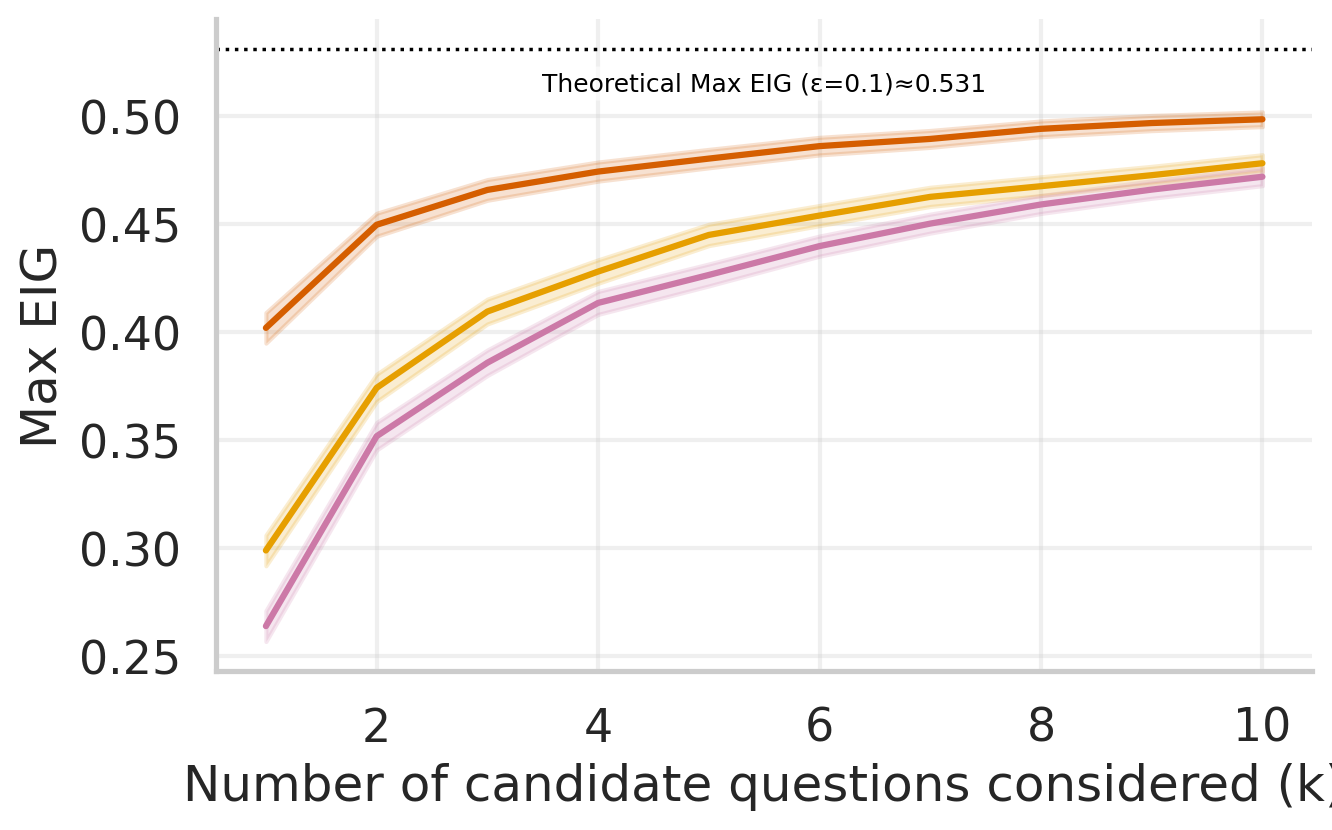

,llm_display,k,mean,count,std,se
0,gpt-4o,1,0.298652,771,0.197228,0.007103
1,gpt-4o,2,0.373950,766,0.174714,0.006313
2,gpt-4o,3,0.409273,763,0.158747,0.005747
3,gpt-4o,4,0.427786,760,0.149665,0.005429
4,gpt-4o,5,0.444742,759,0.136080,0.004939


In [107]:
# Running max EIG vs number of candidate questions per LLM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configurable captain type display to analyze
CAPTAIN_TYPE_DISPLAY = "EIG"  # change this to any value present in model_eig_df['captain_type_display']

required_cols = {"llm_display", "captain_type_display", "eig_candidates"}
missing = required_cols - set(model_question_df.columns)
assert not missing, f"model_eig_df missing required columns: {missing}"  # Fail fast

subset = model_question_df[model_question_df["captain_type_display"] == CAPTAIN_TYPE_DISPLAY].copy()
if subset.empty:
    print(f"No rows with captain_type_display == '{CAPTAIN_TYPE_DISPLAY}'.")
else:
    preview = None
    for v in subset["eig_candidates"]:
        if isinstance(v, list) and v:
            preview = v[:3]
            break
    print("Preview eig_candidates (first 3 of first non-empty row):", preview)

    def extract_eigs(candidates):
        if not isinstance(candidates, list):
            return []
        vals = []
        for item in candidates:
            if isinstance(item, (list, tuple)) and len(item) >= 2:
                val = item[1]
                if val is not None:
                    try:
                        vals.append(float(val))
                    except Exception:
                        pass
            elif isinstance(item, dict):
                for k in ["eig", "EIG", "value"]:
                    if k in item and item[k] is not None:
                        try:
                            vals.append(float(item[k]))
                        except Exception:
                            pass
                        break
        return vals

    records = []
    for _, row in subset.iterrows():
        eigs = extract_eigs(row["eig_candidates"])
        if not eigs:
            continue
        running_max = np.maximum.accumulate(eigs)
        for k, val in enumerate(running_max, start=1):
            records.append({
                "llm_display": row["llm_display"],
                "k": k,
                "running_max_eig": val,
            })

    curve_df = pd.DataFrame(records)
    if curve_df.empty:
        print("No candidate EIG values extracted.")
    else:
        agg = (
            curve_df.groupby(["llm_display", "k"])
            ["running_max_eig"].agg(["mean", "count", "std"]).reset_index()
        )
        agg["se"] = agg["std"] / np.sqrt(agg["count"]).replace(0, np.nan)

        fig, ax = plt.subplots(figsize=(7, 4.5))
        palette = llm_palette if 'llm_palette' in globals() else None
        for llm_name, g in agg.groupby("llm_display"):
            g_sorted = g.sort_values("k")
            color = palette.get(llm_name, None) if palette else None
            ax.plot(g_sorted["k"], g_sorted["mean"], label=llm_name, color=color)
            if g_sorted["se"].notna().any():
                ax.fill_between(
                    g_sorted["k"],
                    g_sorted["mean"] - g_sorted["se"],
                    g_sorted["mean"] + g_sorted["se"],
                    alpha=0.18,
                    color=color,
                )
        # Add theoretical max EIG horizontal line if available
        if 'THEORETICAL_MAX_EIG' in globals():
            ax.axhline(THEORETICAL_MAX_EIG, color='k', linestyle=':', linewidth=1.25, label=f"Theoretical max (ε={EIG_EPSILON})")
            xmin, xmax = ax.get_xlim()
            x_center = 0.5 * (xmin + xmax)
            ax.text(
                x_center,
                THEORETICAL_MAX_EIG * 0.98,
                f"Theoretical Max EIG (ε={EIG_EPSILON})≈{THEORETICAL_MAX_EIG:.3f}",
                va="top",
                ha="center",
                fontsize=9,
                color="k",
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.6, edgecolor="none"),
            )

        ax.set_xlabel("Number of candidate questions considered (k)")
        ax.set_ylabel("Max EIG")
        # ax.set_title(f"Growth of max EIG with candidate set size (captain = {CAPTAIN_TYPE_DISPLAY})")
        # ax.legend(title="LLM")
        ax.grid(alpha=0.3, linestyle="-")

        sns.despine()
        plt.tight_layout()

        plt.savefig(
            os.path.join(PATH_EXPORT, "eig_max_vs_k.pdf"),
            bbox_inches='tight',
            dpi=300
        )

        plt.show()
        display(agg.head())

### Human question EIG

In [ ]:
# --- Human Question EIG Calculation ------------------------------------------
# Computes EIG for human questions and caches to human_eig_df.csv (≈1–2 min first run).
from pathlib import Path
import os, json
import pandas as pd

INPUT_JSON_PATH = resolve_project_path(
    "experiments/collaborative/spotter_benchmarks/o4-mini_CodeSpotterModel_True.json"
)
CACHE_PATH = Path("human_eig_df.csv")


# def load_human_interactions(json_path: Path) -> list[dict]:
#     with json_path.open() as f:
#         return json.load(f)


# def build_human_df(entries: list[dict]) -> pd.DataFrame:
#     rows = []
#     for e in entries:
#         if not ("question" in e and "occTiles" in e):
#             continue
#         answer = e.get("answer", "").lower()
#         # Normalize boolean text answers.
#         if answer == "true":
#             answer = "yes"
#         elif answer == "false":
#             answer = "no"
#         true_answer = e.get("true_answer")
#         rows.append(
#             {
#                 "question": e.get("question"),
#                 "program": e.get("program"),
#                 "board_state": e.get("occTiles"),
#                 "answer": answer,
#                 "true_answer": true_answer,
#                 "correct": answer == true_answer,
#             }
#         )
#     return pd.DataFrame(rows)

# RUN_ANALYSIS = False

# if RUN_ANALYSIS:
#     if CACHE_PATH.exists():
#         human_eig_df = pd.read_csv(CACHE_PATH)
#     else:
#         raw_entries = load_human_interactions(Path(INPUT_JSON_PATH))
#         human_eig_df = build_human_df(raw_entries)
#         # Keep only correctly answered questions.
#         human_eig_df = human_eig_df[human_eig_df["correct"]]

#         eig_calculator = EIGCalculator(samples=1000, timeout=15, epsilon=0)
#         human_eig_df["calculated_eig"] = None

#         for idx, row in human_eig_df.iterrows():
#             code_question = CodeQuestion(
#                 question=Question(row["question"]),
#                 fn_text=row["program"],
#                 translation_prompt="",
#                 completion={},
#             )
#             board = Board.from_occ_tiles(row["board_state"])  # reconstruct board
#             human_eig_df.at[idx, "calculated_eig"] = eig_calculator(code_question, board)

#         human_eig_df.to_csv(CACHE_PATH, index=False)

#     human_eig_df

In [109]:
def calculate_human_eig():
    """
    Calculate EIG for human questions by:
    - Loading questions from stage.csv where messageType = "question"
    - Looking up previous questions in o4-mini_CodeSpotterModel_True.json to extract code questions
    - Getting true board tiles from round.csv 
    - Computing EIG for each question using EIGCalculator with constraints
    - Returning the EIG dataframe
    """
    import pandas as pd
    import json
    import ast
    import numpy as np
    from pathlib import Path
    from battleship.agents import EIGCalculator, CodeQuestion, Question
    from battleship.board import Board

    # Load stage data for questions
    stage_path = Path(PATH_DATA) / "stage.csv"
    if not stage_path.exists():
        print(f"Error: {stage_path} not found")
        return pd.DataFrame()

    stage_df = pd.read_csv(stage_path)
    print(f"Loaded {len(stage_df)} stage entries")

    # Load round data for true board tiles
    rounds_path = Path(PATH_DATA) / "round.csv"
    if not rounds_path.exists():
        print(f"Error: {rounds_path} not found")
        return pd.DataFrame()

    rounds_df = pd.read_csv(rounds_path)
    print(f"Loaded {len(rounds_df)} rounds")

    # Load spotter data for code questions
    spotter_json_path = resolve_project_path(
        "experiments/collaborative/spotter_benchmarks/o4-mini_CodeSpotterModel_True.json"
    )

    if not Path(spotter_json_path).exists():
        print(f"Error: {spotter_json_path} not found")
        return pd.DataFrame()

    with open(spotter_json_path, 'r') as f:
        spotter_data = json.load(f)

    print(f"Loaded {len(spotter_data)} spotter entries")

    # Create lookup dictionary for code questions using composite key
    code_question_lookup = {}
    
    for entry in spotter_data:
        if "question" in entry and "program" in entry:
            key = (entry["question"], entry["roundID"], entry["questionID"])
            code_question_lookup[key] = {
                "program": entry["program"],
                "board_state": entry["occTiles"],
                "answer": entry["answer"],
                "true_answer": entry["true_answer"]
            }

    print(f"Created lookup for {len(code_question_lookup)} code questions")

    # Create lookup for true board tiles by round ID
    round_boards_lookup = {}
    for _, round_row in rounds_df.iterrows():
        round_id = round_row["id"]
        true_tiles_str = round_row["trueTiles"]
        true_tiles = ast.literal_eval(true_tiles_str)
        round_boards_lookup[round_id] = np.array(true_tiles)

    # Filter stages to only questions
    question_stages = stage_df[stage_df["messageType"] == "question"].copy()
    print(f"Found {len(question_stages)} question stages")

    # Extract questions from stage data
    eig_records = []
    eig_calculator = EIGCalculator(samples=1000, timeout=15, epsilon=0.1)

    question_count = 0
    matched_questions = 0
    lost_questions = 0

    # Group question stages by roundID to process games
    for round_idx, (round_id, round_stages) in enumerate(question_stages.groupby("roundID")):
        print(f"Processing round {round_idx} ({round_id}) with {len(round_stages)} questions")

        # Get true board for this round
        if round_id not in round_boards_lookup:
            print(f"Skipping round {round_id}: no true board data found")
            continue

        true_board = Board(round_boards_lookup[round_id])

        # Sort stages by index to maintain chronological order
        round_stages = round_stages.sort_values("index")

        # Collect all questions and answers from this round to build constraints
        game_questions = []

        # First pass: collect all correctly answered questions as potential constraints
        for _, stage in round_stages.iterrows():
            question_text = stage.get("messageText", "")
            stage_round_id = stage.get("roundID")
            question_id = stage.get("questionID")

            lookup_key = (question_text, stage_round_id, question_id)
            if lookup_key in code_question_lookup:
                code_data = code_question_lookup[lookup_key]

                # Only include correctly answered questions as potential constraints
                if code_data["answer"] == code_data["true_answer"]:
                    answer_value = None
                    if code_data["true_answer"].lower() == "yes":
                        answer_value = True
                    elif code_data["true_answer"].lower() == "no":
                        answer_value = False

                    if answer_value is not None:
                        try:
                            constraint_code_question = CodeQuestion(
                                question=Question(question_text),
                                fn_text=code_data["program"],
                                translation_prompt="",
                                completion={}
                            )
                            game_questions.append((constraint_code_question, answer_value))
                        except Exception as e:
                            print(f"Error creating constraint CodeQuestion: {e}")
                            continue

        # Second pass: process each question for EIG calculation
        for _, stage in round_stages.iterrows():
            question_count += 1
            question_text = stage.get("messageText", "")
            stage_round_id = stage.get("roundID")
            question_id = stage.get("questionID")

            lookup_key = (question_text, stage_round_id, question_id)

            if not question_text or lookup_key not in code_question_lookup:
                print(f"Skipping question with no spotter response: {question_text}")
                lost_questions += 1
                continue

            matched_questions += 1
            code_data = code_question_lookup[lookup_key]

        # try:
            # Create partial board from occluded tiles at the time of this question
            partial_board = Board.from_occ_tiles(code_data["board_state"])

            # Create ship tracker by comparing true board vs partial board
            ship_tracker = true_board.ship_tracker(partial_board)

            # Create code question for this EIG calculation
            code_question = CodeQuestion(
                question=Question(question_text),
                fn_text=code_data["program"],
                translation_prompt="",
                completion={}
            )

            # Build constraints from all previous questions in this game
            # Find the index of current question in game_questions list
            current_question_idx = -1
            for i, (cq, _) in enumerate(game_questions):
                if cq.question.text == question_text:
                    current_question_idx = i
                    break

            # Use all questions before this one as constraints
            constraints = []
            if current_question_idx > 0:
                constraints = game_questions[:current_question_idx]

            # Calculate EIG with ship tracker and constraints
            eig_value = eig_calculator(code_question, partial_board,
                                    ship_tracker=ship_tracker,
                                    constraints=constraints)
            eig_records.append({
                "round_id": round_id,
                "question_id": question_id,
                "stage_id": stage["id"],
                "stage_index": stage.get("index", 0),
                "question": question_text,
                "program": code_data["program"],
                "eig": eig_value,
                "captain_type": "Human",
                "answer": code_data["true_answer"],
                "n_constraints": len(constraints),
                "ship_tracker": ship_tracker
            })

            # except Exception as e:
            #     print(f"Error processing question '{question_text}': {e}")
            #     continue

    print(f"Total questions found: {question_count}")
    print(f"Matched questions: {matched_questions}")

    if not eig_records:
        print("No EIG records generated")
        return pd.DataFrame()

    # Convert to DataFrame
    result_df = pd.DataFrame(eig_records)
    print(f"Generated {len(result_df)} EIG calculations with ship tracker and constraints")
    print(f"Lost questions: {lost_questions}")
    print(f"Matched questions: {matched_questions}")

    return result_df

RUN_ANALYSIS = False

if RUN_ANALYSIS:
    # Execute the function
    human_eig_df = calculate_human_eig()

    human_eig_df["llm_display"] = "Human"
    human_eig_df["captain_type_display"] = "Human"
    human_eig_df.to_csv(CACHE_PATH, index=False)

/tmp/ipykernel_1124/43376640.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


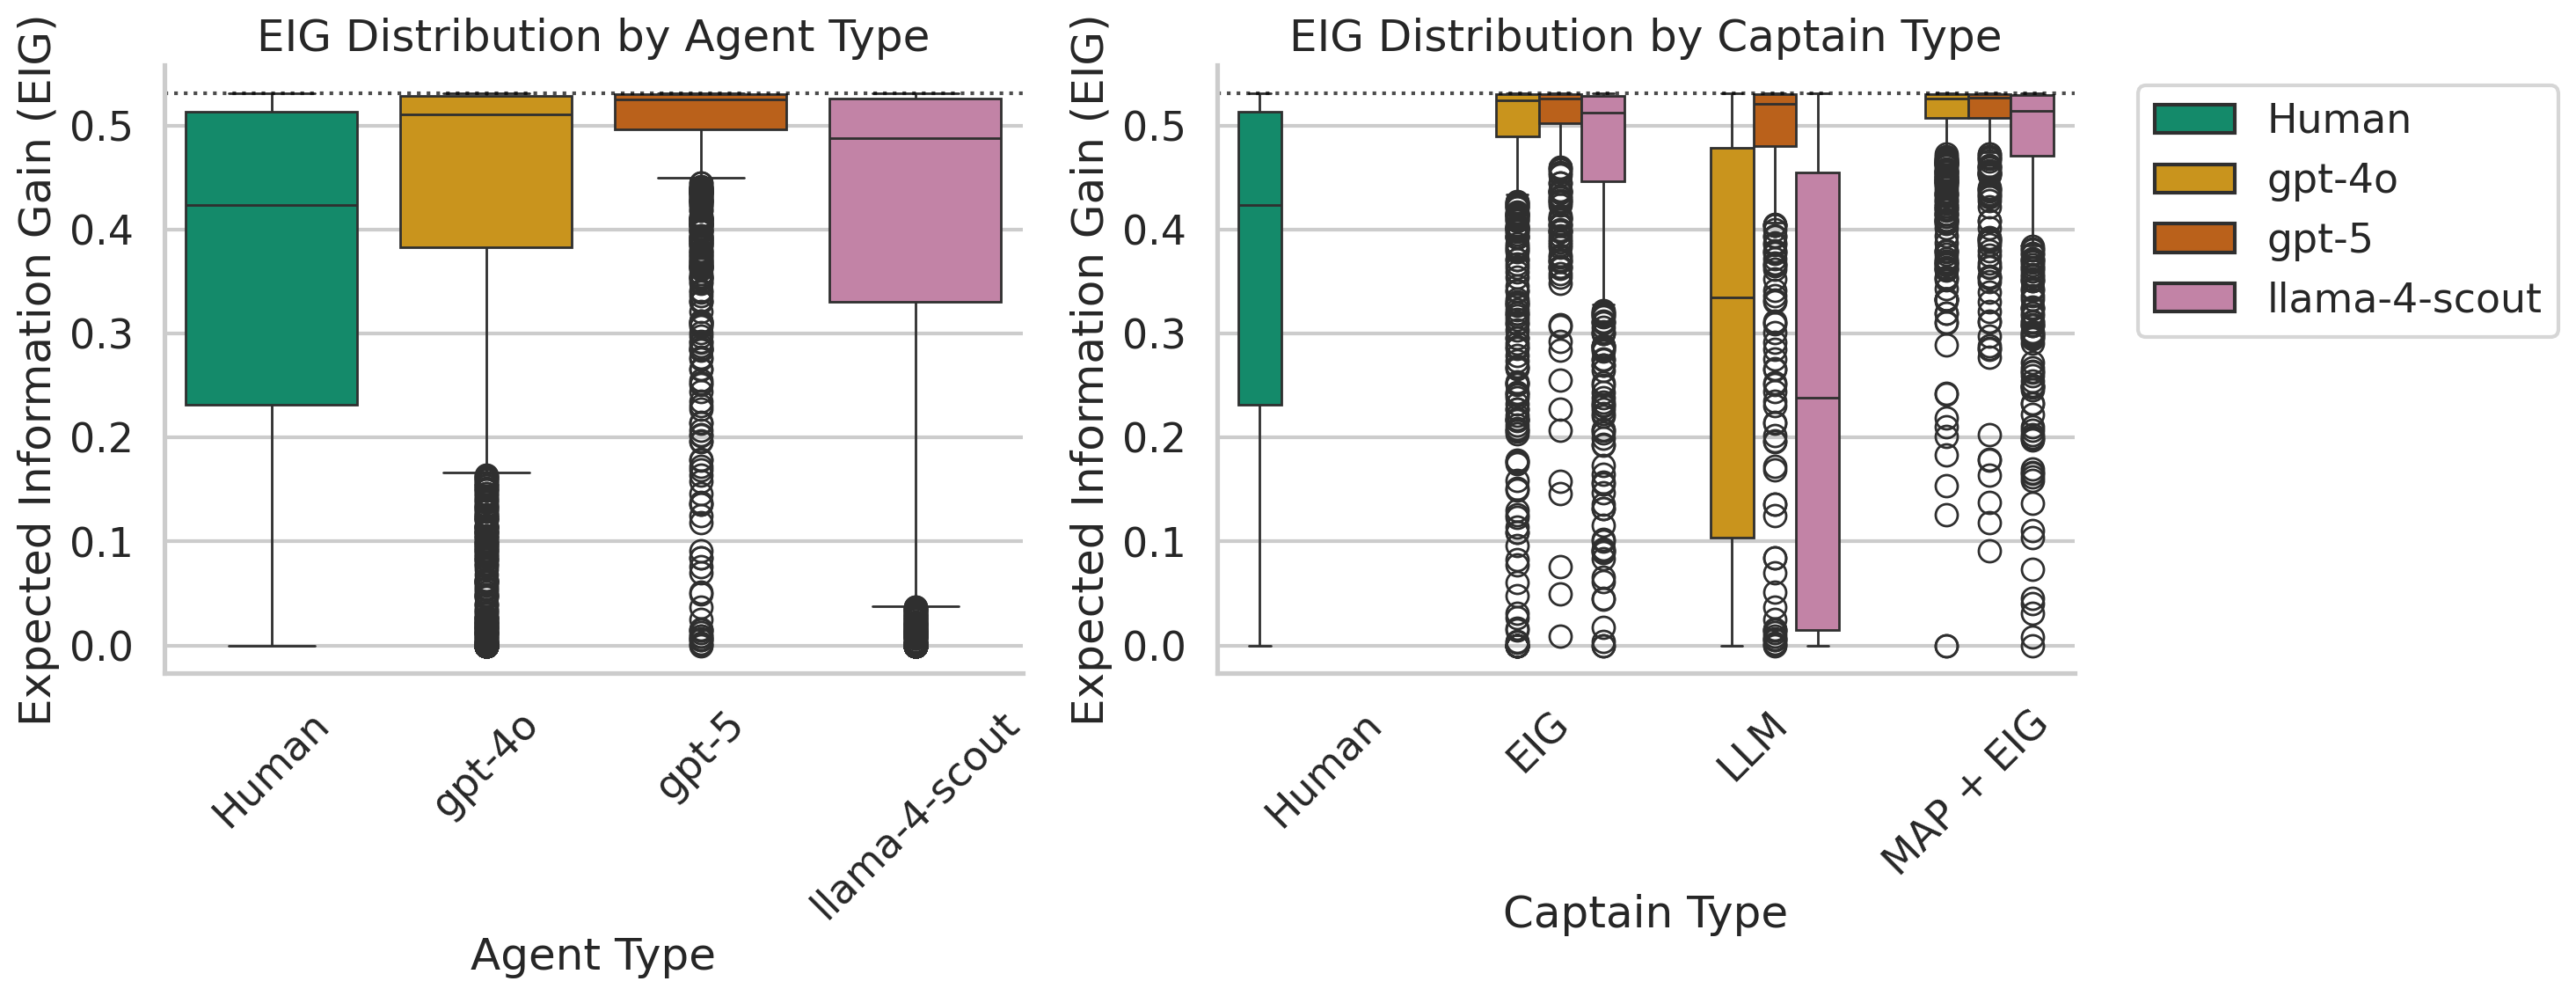

In [110]:
# --- Compare EIG Distributions (Model vs Human) by Captain Type --------------
# Combine human and model EIG data for comparison

import matplotlib.pyplot as plt

# Read the CSV file and load it into a DataFrame
human_eig_df = pd.read_csv(resolve_project_path("experiments/collaborative/human_eig_df.csv"))

human_eig_data = human_eig_df[['eig', 'llm_display', 'captain_type_display']].copy()
model_eig_data = model_question_df[['eig', 'llm_display', 'captain_type_display']].copy()

# Combine datasets
combined_eig_df = pd.concat([human_eig_data, model_eig_data], ignore_index=True)

# Create comparison plot with captain type breakdown
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Boxplot by LLM type
sns.boxplot(
    data=combined_eig_df, 
    x="llm_display", 
    y="eig", 
    palette=llm_palette,
    ax=axes[0]
)
axes[0].set_title("EIG Distribution by Agent Type")
axes[0].set_xlabel("Agent Type")
axes[0].set_ylabel("Expected Information Gain (EIG)")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Boxplot by captain type, colored by LLM
sns.boxplot(
    data=combined_eig_df, 
    x="captain_type_display", 
    y="eig", 
    hue="llm_display",
    palette=llm_palette,
    ax=axes[1]
)
axes[1].set_title("EIG Distribution by Captain Type")
axes[1].set_xlabel("Captain Type")
axes[1].set_ylabel("Expected Information Gain (EIG)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add theoretical max EIG line to both plots
if 'THEORETICAL_MAX_EIG' in globals():
    for ax in axes:
        ax.axhline(THEORETICAL_MAX_EIG, color='k', linestyle=':', linewidth=1.5, alpha=0.7)

sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(PATH_EXPORT, "human_vs_model_eig_by_captain_type.pdf"), dpi=300, bbox_inches="tight")
plt.show()


## Question timing analysis
When do humans and models ask questions during the game?

In [ ]:
stage_df_human = load_dataset(experiment_path=PATH_DATA, use_gold=True)

stage_df_human["captain_type"] = "Human"
stage_df_human["captain_type_display"] = "Human"
stage_df_human["llm"] = "Human"
stage_df_human["llm_display"] = "Human"

stage_df_human = stage_df_human.rename(columns={"roundID": "round_id"})

stage_df_human

In [ ]:
# Filter on "question" rows
stage_df_human_question = stage_df_human[stage_df_human["questionAsked"] == True]
stage_df_human_question["question"] = stage_df_human_question["messageText"]

In [ ]:
stage_df_question = pd.concat(
    [stage_df_human_question, model_question_df], axis="rows", ignore_index=True
)
stage_df_question

In [ ]:
model_question_df.columns

In [ ]:
model_question_df[(model_question_df.captain_type_display == "LLM") & (model_question_df.llm_display == "llama-4-scout")].groupby(
    ["captain_type_display", "llm_display", "board_id", "seed"], observed=True
)["question"].count().to_frame().to_csv("llm-llama-4-scout.csv")

In [ ]:
model_question_df[
    (model_question_df.captain_type_display == "LLM")
    & (model_question_df.llm_display == "llama-4-scout")
    & (model_question_df.board_id == "B10")
    & (model_question_df.seed == 1337)
].round_id.unique()

In [ ]:
# Plot with common normalization (absolute density comparable across LLMs)
fig_norm, ax_norm = plot_question_timing(
    stage_df=stage_df_question,
    llm_palette=llm_palette,
    captain_types=["Human", "LLM"],
    common_norm=True,
    legend=False,
    fig_width=6,
    fig_height=4,
    output_path=os.path.join(PATH_EXPORT, "question_timing.pdf"),
)

In [ ]:
sns.violinplot(
    data=stage_df_question[
        stage_df_question["captain_type_display"].isin(["Human", "LLM"])
    ].copy(),
    x="stage_completion",
    y="captain_type_display",
    hue="llm_display",
    palette=llm_palette,
    common_norm=False,
    density_norm="area",
    legend=False,
)

In [ ]:
sns.barplot(
    data=df,
    # kind="ecdf",
    y="question_count",
    x="captain_type_display",
    hue="llm_display",
    palette=llm_palette,
    # stat="proportion",
    # common_norm=False,
)

In [ ]:
sns.relplot(
    data=df,
    col="captain_type_display",
    x="question_count",
    y="f1_score",
    hue="llm_display",
    palette=llm_palette,
)

## Question content analysis

In [ ]:
stage_df_question

### Question Embedding & Content Clustering
We embed each unique question (human + model) using the OpenAI `text-embedding-3-small` model with robust on-disk caching to avoid recomputation. Then we explore two clustering / visualization approaches:

1. t-SNE (after PCA) + k-means.
2. UMAP + HDBSCAN (density based; can assign noise).

Columns propagated:
- `question`
- `captain_type_display`
- `llm_display`

Caching:
- Cache file `question_embeddings_cache.pkl` stores columns: `question`, `embedding` (list[float]), `model`.
- Only new questions are sent to the API.
- Safe failure if API key not present or request errors occur.

Methodology notes:
- Questions are stripped & deduplicated.
- PCA(50) => t-SNE(2) for speed/stability; perplexity auto-tuned.
- k-means k chosen heuristically (bounded) with silhouette printed.
- UMAP(2) then HDBSCAN; noise labeled -1.
- Representative exemplar questions per cluster selected by cosine similarity to cluster centroid.

Outputs:
- `question_embeddings_df`: per unique question embedding table.
- `stage_df_question_emb`: original `stage_df_question` with embedding-derived projections & cluster labels.
- Figures saved under `PATH_EXPORT`.


In [ ]:
# Embedding generation & caching
import os, time, pickle, math, sys
from pathlib import Path
import pandas as pd
import numpy as np
from typing import List, Dict, Any

try:
    from openai import OpenAI
    _openai_available = True
except Exception:
    _openai_available = False

EMBED_MODEL = "text-embedding-3-small"
EMBED_CACHE_PATH = Path("question_embeddings_cache.pkl")
BATCH_SIZE = 500  # OpenAI recommends batching for efficiency
SLEEP_BETWEEN_BATCHES = 0.4  # basic pacing; adjust if rate limited

# Prepare unique questions
assert 'stage_df_question' in globals(), "stage_df_question missing. Run earlier cells."
questions_series = stage_df_question['question'].astype(str).str.strip()
unique_questions = pd.Series(sorted(set(q for q in questions_series if q)))

# Load cache if exists
if EMBED_CACHE_PATH.exists():
    with EMBED_CACHE_PATH.open('rb') as f:
        cache_df = pickle.load(f)
    if not isinstance(cache_df, pd.DataFrame) or 'question' not in cache_df.columns or 'embedding' not in cache_df.columns:
        print("Cache format invalid; rebuilding.")
        cache_df = pd.DataFrame(columns=['question','embedding','model'])
else:
    cache_df = pd.DataFrame(columns=['question','embedding','model'])

cached_set = set(cache_df['question'])
missing_questions = [q for q in unique_questions if q not in cached_set]
print(f"Total unique questions: {len(unique_questions)} | Cached: {len(cached_set)} | Missing: {len(missing_questions)}")

client = None
if missing_questions and _openai_available:
    api_key = os.getenv('OPENAI_API_KEY')
    if not api_key:
        print("OPENAI_API_KEY not set; skipping new embeddings.")
    else:
        client = OpenAI(api_key=api_key)

new_rows = []
if client and missing_questions:
    for i in range(0, len(missing_questions), BATCH_SIZE):
        batch = missing_questions[i:i+BATCH_SIZE]
        try:
            resp = client.embeddings.create(input=batch, model=EMBED_MODEL)
            # The response order matches the input order
            for q, d in zip(batch, resp.data):
                new_rows.append({
                    'question': q,
                    'embedding': d.embedding,
                    'model': EMBED_MODEL,
                })
        except Exception as e:
            print(f"Embedding batch failed at index {i}: {e}")
            # Simple fallback: skip remaining
            break
        time.sleep(SLEEP_BETWEEN_BATCHES)

if new_rows:
    cache_df = pd.concat([cache_df, pd.DataFrame(new_rows)], ignore_index=True)
    # Drop duplicates favoring first occurrence (oldest) to avoid churn
    cache_df = cache_df.sort_values('question').drop_duplicates('question', keep='first')
    with EMBED_CACHE_PATH.open('wb') as f:
        pickle.dump(cache_df, f)
    print(f"Cached embeddings updated with {len(new_rows)} new rows.")

# Final embedding dataframe
question_embeddings_df = cache_df.copy()
print(question_embeddings_df.head())
print(f"Embedding dim (first row): {len(question_embeddings_df.iloc[0].embedding) if not question_embeddings_df.empty else 'NA'}")

In [ ]:
# Join embeddings back to full question rows (many rows may share a question string)
assert 'stage_df_question' in globals(), "stage_df_question missing"

emb_map = question_embeddings_df.set_index('question')['embedding'].to_dict()

SUBSET = stage_df_question[stage_df_question['captain_type_display'].isin(['Human', 'LLM'])]
stage_df_question_emb = SUBSET.copy()

stage_df_question_emb['embedding'] = stage_df_question_emb['question'].map(emb_map)
missing_emb = stage_df_question_emb['embedding'].isna().sum()
print(f"Rows without embedding (likely due to API skip or empty text): {missing_emb}")

# Drop rows without embeddings for downstream projections
stage_df_question_emb = stage_df_question_emb.dropna(subset=['embedding']).reset_index(drop=True)

stage_df_question_emb.head()

In [ ]:
# t-SNE + k-means: Dimensionality Reduction & Clustering (compute only)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Flags / config
PCA_COMPONENTS = 50
TSNE_PERPLEXITY_HEURISTIC_DIVISOR = 150
TSNE_MAX_PERPLEXITY = 40
TSNE_MIN_PERPLEXITY = 5
K_RANGE = range(2, 30)
RANDOM_STATE = 42
FORCE_RECOMPUTE_REDUCTION = False   # Force BOTH PCA and t-SNE
FORCE_RECOMPUTE_KMEANS = True      # Force k-means reselection / refit

# Build embedding matrix (will raise if missing)
X = np.vstack(stage_df_question_emb['embedding'].tolist())
emb_dim = X.shape[1]
print(f"Embedding matrix shape: {X.shape}")

# PCA (recompute if forced or cache absent / size mismatch)
recompute_pca = (
    FORCE_RECOMPUTE_REDUCTION or
    ('X_pca_cached' not in globals()) or
    (globals().get('X_pca_cached').shape[0] != X.shape[0])
)
if recompute_pca:
    pca_dim = min(PCA_COMPONENTS, emb_dim)
    pca_model = PCA(n_components=pca_dim, random_state=RANDOM_STATE)
    X_pca = pca_model.fit_transform(X)
    X_pca_cached = X_pca
    pca_model_cached = pca_model
    print(f"Computed PCA: shape={X_pca.shape}")
    print("Explained variance (first 10 comps):", pca_model.explained_variance_ratio_[:10].round(4))
else:
    X_pca = X_pca_cached
    pca_model = pca_model_cached
    print("Reusing cached PCA result.")

# t-SNE (recompute if forced or coordinates missing)
recompute_tsne = FORCE_RECOMPUTE_REDUCTION or ('tsne_x' not in stage_df_question_emb.columns) or ('tsne_y' not in stage_df_question_emb.columns)
if recompute_tsne:
    n_samples = X_pca.shape[0]
    perplexity = min(TSNE_MAX_PERPLEXITY, max(TSNE_MIN_PERPLEXITY, n_samples // TSNE_PERPLEXITY_HEURISTIC_DIVISOR))
    perplexity = max(2, min(perplexity, n_samples - 1))
    print(f"Computing t-SNE with perplexity={perplexity}")
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='pca', random_state=RANDOM_STATE)
    X_tsne = tsne.fit_transform(X_pca)
    stage_df_question_emb['tsne_x'] = X_tsne[:, 0]
    stage_df_question_emb['tsne_y'] = X_tsne[:, 1]
else:
    print("Reusing existing t-SNE coordinates (set FORCE_RECOMPUTE_REDUCTION=True to recompute).")

# k-means model selection (recompute if forced or labels absent)
recompute_kmeans = FORCE_RECOMPUTE_KMEANS or ('kmeans_label' not in stage_df_question_emb.columns)
if recompute_kmeans:
    n_samples = X_pca.shape[0]
    possible_k = [k for k in K_RANGE if k < n_samples]
    best_k = None
    best_score = -1
    for k in possible_k:
        km = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE)
        labels = km.fit_predict(X_pca)
        if len(set(labels)) > 1:
            try:
                score = silhouette_score(X_pca, labels)
            except Exception:
                score = np.nan
        else:
            score = np.nan
        print(f"k={k}: silhouette={score:.3f}")
        if not np.isnan(score) and score > best_score:
            best_score = score
            best_k = k
    if best_k is None:
        best_k = 5
        print("Silhouette selection failed; defaulting k=5")
    print(f"Selected k={best_k} (silhouette={best_score:.3f})")
    kmeans_model = KMeans(n_clusters=best_k, n_init='auto', random_state=RANDOM_STATE)
    k_labels = kmeans_model.fit_predict(X_pca)
    stage_df_question_emb['kmeans_k'] = best_k
    stage_df_question_emb['kmeans_label'] = k_labels
    kmeans_model_cached = kmeans_model
else:
    print("Reusing existing k-means labels (set FORCE_RECOMPUTE_KMEANS=True to recompute).")

# Cluster size summary
cluster_sizes = (stage_df_question_emb
                 .groupby('kmeans_label')
                 .size()
                 .reset_index(name='count')
                 .sort_values('count', ascending=False))
print("Cluster size summary (top 20):")
display(cluster_sizes.head(20))

print("Dimensionality reduction & clustering step complete.")

In [ ]:
# t-SNE plotting utility: configurable coloring + optional stochastic point representatives + optional per-group KDE background
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, os, textwrap
from typing import Optional

# Global configuration defaults (override per call)
TSNE_POINT_SIZE = 18
TSNE_ALPHA = 0.85
TSNE_RANDOM_STATE = 42
TSNE_WRAP_WIDTH = 55
TSNE_MAX_CHARS = 160
TSNE_SAVE_FIGS = True
TSNE_SAVE_REPS = True
REP_EPS = 1e-9  # epsilon to avoid div-by-zero in distance weighting


def _select_representatives(
    df: pd.DataFrame,
    group_col: str,
    embedding_col: str,
    pca_model,
    n_examples: int,
    max_chars: int = 160,
    seed: Optional[int] = None,
) -> pd.DataFrame:
    """Select N representative rows per group via stochastic distance-weighted sampling."""
    if n_examples <= 0:
        return pd.DataFrame()
    if pca_model is None:
        raise RuntimeError("PCA model required for representative selection.")

    rng = np.random.default_rng(seed)
    X = np.vstack(df[embedding_col].tolist())
    X_pca = pca_model.transform(X)
    labels = df[group_col].to_numpy()
    unique_groups = sorted(pd.unique(labels))

    records = []
    for g in unique_groups:
        mask = labels == g
        if mask.sum() == 0:
            continue
        pts = X_pca[mask]
        centroid = pts.mean(axis=0)
        dists = np.linalg.norm(pts - centroid, axis=1)
        weights = 1.0 / (dists + REP_EPS)
        weights = weights / weights.sum()
        orig_indices = df.index[mask].to_numpy()
        k = min(n_examples, len(orig_indices))
        if k == len(orig_indices):
            chosen_local = np.arange(k)
        else:
            chosen_local = rng.choice(len(orig_indices), size=k, replace=False, p=weights)
        chosen_global = orig_indices[chosen_local]
        rep_questions, rep_indices, rep_cols, rep_idx_cols = [], [], {}, {}
        for j, idx_row in enumerate(chosen_global):
            q = df.loc[idx_row, 'question']
            q_trunc = q[:max_chars] if isinstance(q, str) else str(q)
            rep_questions.append(q_trunc)
            rep_indices.append(int(idx_row))
            rep_cols[f'rep{j+1}'] = q_trunc
            rep_idx_cols[f'rep_idx{j+1}'] = int(idx_row)
        records.append({
            group_col: g,
            'size': int(mask.sum()),
            'rep_questions': rep_questions,
            'rep_indices': rep_indices,
            'example_question': rep_questions[0] if rep_questions else None,
            **rep_cols,
            **rep_idx_cols,
        })

    return pd.DataFrame(records).sort_values(group_col).reset_index(drop=True)


def plot_tsne_groups(
    df: pd.DataFrame,
    color_col: str,
    *,
    tsne_x: str = 'tsne_x',
    tsne_y: str = 'tsne_y',
    embedding_col: str = 'embedding',
    pca_model=None,
    n_label_examples: int = 0,
    label_wrap_width: int = TSNE_WRAP_WIDTH,
    max_chars: int = TSNE_MAX_CHARS,
    point_size: int = TSNE_POINT_SIZE,
    alpha: float = TSNE_ALPHA,
    palette=None,
    title: Optional[str] = None,
    outfile: Optional[str] = None,
    save_reps: bool = False,
    legend: bool = True,
    random_state: int = TSNE_RANDOM_STATE,
    fig_width: float = 7,
    fig_height: float = 5,
    rep_seed: Optional[int] = None,
    # KDE options
    show_kde: bool = False,
    kde_fill: bool = True,
    kde_thresh: float = 0.02,
    kde_alpha: float = 0.40,
    kde_bw_method: Optional[float] = None,
    kde_common_norm: bool = False,
) -> Optional[pd.DataFrame]:
    """Generic t-SNE scatter with optional per-point representative labels and per-group KDE background.

    KDE now uses hue=color_col so each group has its own density.
    Legend updated: uses rectangular patches instead of point markers.
    """
    required_cols = {tsne_x, tsne_y, color_col}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns for plotting: {missing}")

    # Derive palette
    if palette is None:
        if color_col == 'kmeans_label':
            palette = 'tab10'
        elif color_col == 'llm_display' and 'llm_palette' in globals():
            palette = llm_palette
        else:
            palette = 'Set2'

    plot_df = df

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Per-group KDE background
    if show_kde:
        sns.kdeplot(
            data=plot_df,
            x=tsne_x,
            y=tsne_y,
            hue=color_col,
            fill=kde_fill,
            thresh=kde_thresh,
            alpha=kde_alpha,
            bw_method=kde_bw_method,
            common_norm=kde_common_norm,
            palette=palette,
            ax=ax,
            legend=False,
        )

    # Build a color map for later legend Patch handles
    unique_vals = list(plot_df[color_col].dropna().unique())
    if isinstance(palette, dict):
        color_map = {k: palette.get(k, '#808080') for k in unique_vals}
    else:
        pal_colors = sns.color_palette(palette, n_colors=len(unique_vals))
        color_map = dict(zip(unique_vals, pal_colors))

    sns.scatterplot(
        data=plot_df,
        x=tsne_x, y=tsne_y,
        hue=color_col,
        palette=color_map,  # pass explicit mapping
        s=point_size,
        linewidth=0,
        ax=ax,
        alpha=alpha,
        zorder=3 if show_kde else 1,
        legend=False,  # disable automatic legend so we can substitute patches
    )

    # Custom rectangular legend
    if legend:
        from matplotlib.patches import Patch
        handles = [
            Patch(facecolor=color_map[v], edgecolor='none', label=str(v), alpha=alpha)
            for v in unique_vals
        ]
        ax.legend(
            handles=handles,
            bbox_to_anchor=(0.5, 1),
            loc='upper center',
            title=None,
            ncol=len(unique_vals),
            frameon=True,
        )

    if title:
        ax.set_title(title)
    ax.set_xlabel('t-SNE 1'); ax.set_ylabel('t-SNE 2')

    reps_df = None
    if n_label_examples > 0:
        if pca_model is None:
            raise RuntimeError("pca_model required for representative labels.")
        reps_df = _select_representatives(
            df=df,
            group_col=color_col,
            embedding_col=embedding_col,
            pca_model=pca_model,
            n_examples=n_label_examples,
            max_chars=max_chars,
            seed=rep_seed,
        )
        for _, row in reps_df.iterrows():
            rep_indices = row.get('rep_indices', [])
            rep_questions = row.get('rep_questions', [])
            for idx_pt, q_text in zip(rep_indices, rep_questions):
                pt = df.loc[idx_pt]
                x_pt = pt[tsne_x]
                y_pt = pt[tsne_y]
                short = textwrap.shorten(str(q_text).replace('\n',' '), width=label_wrap_width, placeholder='…')
                ax.text(
                    x_pt, y_pt, short,
                    ha='center', va='center', fontsize=7.0,
                    bbox=dict(boxstyle='round,pad=0.20', fc='white', ec='none', alpha=0.72),
                    zorder=4,
                )
        if color_col == 'kmeans_label':
            globals()['cluster_reps_df'] = reps_df.copy()
            if save_reps and TSNE_SAVE_REPS:
                reps_path = os.path.join(PATH_EXPORT, 'kmeans_cluster_representatives.csv')
                reps_df.to_csv(reps_path, index=False)
                print(f"Saved representatives -> {reps_path}\n")

    sns.despine(); plt.tight_layout()
    if outfile and TSNE_SAVE_FIGS:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()
    return reps_df

# --- Example usage (k-means clusters) ---
if 'pca_model_cached' not in globals():
    raise RuntimeError("pca_model_cached not found; run compute cell first.")

cluster_reps_df = plot_tsne_groups(
    stage_df_question_emb,
    color_col='kmeans_label',
    pca_model=pca_model_cached,
    n_label_examples=3,
    outfile=os.path.join(PATH_EXPORT, 'questions_tsne_kmeans_with_labels.pdf'),
    save_reps=True,
    fig_width=7,
    fig_height=5,
    rep_seed=123,
    show_kde=True,
)

In [ ]:
# t-SNE colored by Captain Type using unified plot_tsne_groups
if 'pca_model_cached' not in globals():
    raise RuntimeError("pca_model_cached not found; run compute cell first.")

plot_tsne_groups(
    stage_df_question_emb,
    color_col="captain_type_display",
    fig_width=7,
    fig_height=6,
    pca_model=pca_model_cached,
    n_label_examples=5,
    rep_seed=333,
    outfile=os.path.join(PATH_EXPORT, "questions_tsne_captain_type.pdf"),
    save_reps=False,
    show_kde=True,
    alpha=0.5,
    kde_alpha=0.2,
    legend=True,
)
print("Captain type t-SNE plot generated.")

In [ ]:
# t-SNE colored by LLM using unified plot_tsne_groups
if 'pca_model_cached' not in globals():
    raise RuntimeError("pca_model_cached not found; run compute cell first.")

plot_tsne_groups(
    stage_df_question_emb,
    color_col='llm_display',
    pca_model=pca_model_cached,
    outfile=os.path.join(PATH_EXPORT, 'questions_tsne_llm.pdf'),
    save_reps=False,
    legend=True,
    fig_width=7,
    fig_height=7,
    n_label_examples=3,
    rep_seed=111,
    show_kde=False,
)
print("LLM t-SNE plot generated.")